# **AutoEncoders**

1) Autoencoders are data-specific, which means that they will only be able to compress data similar to what they have been trained on. This is different from, say, the MPEG-2 Audio Layer III (MP3) compression algorithm, which only holds assumptions about "sound" in general, but not about specific types of sounds. An autoencoder trained on pictures of faces would do a rather poor job of compressing pictures of trees, because the features it would learn would be face-specific.

2) Autoencoders are lossy, which means that the decompressed outputs will be degraded compared to the original inputs (similar to MP3 or JPEG compression). This differs from lossless arithmetic compression.

3) Autoencoders are learned automatically from data examples, which is a useful property: it means that it is easy to train specialized instances of the algorithm that will perform well on a specific type of input. It doesn't require any new engineering, just appropriate training data.

# **Principal Component Analysis (PCA)**

Imports and Dependencies

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import random
import time
from keras.datasets import cifar10
from sklearn.decomposition import PCA
import keras
import pandas as pd
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity

Data Loading

In [ ]:
# Downloading the dataset (CIFAR-10) using keras.datasets library
def load_dataset():
 # load dataset
 (X_train,y_train),(X_test,y_test) = cifar10.load_data()
 return X_train,y_train,X_test,y_test

# Initial Exploration of the dataset and its dimensions
X_train,y_train,X_test,y_test =  load_dataset()
print("The shape of X_train is :",X_train.shape)
print("The shape of y_train is :",y_train.shape)

print("The shape of X_test is :",X_test.shape)
print("The shape of y_test is :",y_test.shape)

print("The number of unique classes is:",len(np.unique(y_train)))

labels =["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
print("Class Names are:",labels)

170498071/170498071 [==============================] - 13s 0us/step
The shape of X_train is : (50000, 32, 32, 3)
The shape of y_train is : (50000, 1)
The shape of X_test is : (10000, 32, 32, 3)
The shape of y_test is : (10000, 1)
The number of unique classes is: 10
Class Names are: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Data Exploration

In [ ]:
# Check the percentage of each class in the training and the test set
def check_class_percentages(y, dataset_name):
    unique_classes, class_counts = np.unique(y, return_counts=True)
    total_samples = len(y)
    class_percentages = class_counts / total_samples * 100

    print(f"Percentage of each class in the {dataset_name} data:")
    for class_name, percentage in zip(unique_classes, class_percentages):
        print(f"Class {class_name}: {percentage:.2f}%")

# Print class percentages for the training data
check_class_percentages(y_train, "training")

# Print class percentages for the testing data
check_class_percentages(y_test, "testing")

Percentage of each class in the training data:
Class 0: 10.00%
Class 1: 10.00%
Class 2: 10.00%
Class 3: 10.00%
Class 4: 10.00%
Class 5: 10.00%
Class 6: 10.00%
Class 7: 10.00%
Class 8: 10.00%
Class 9: 10.00%
Percentage of each class in the testing data:
Class 0: 10.00%
Class 1: 10.00%
Class 2: 10.00%
Class 3: 10.00%
Class 4: 10.00%
Class 5: 10.00%
Class 6: 10.00%
Class 7: 10.00%
Class 8: 10.00%
Class 9: 10.00%


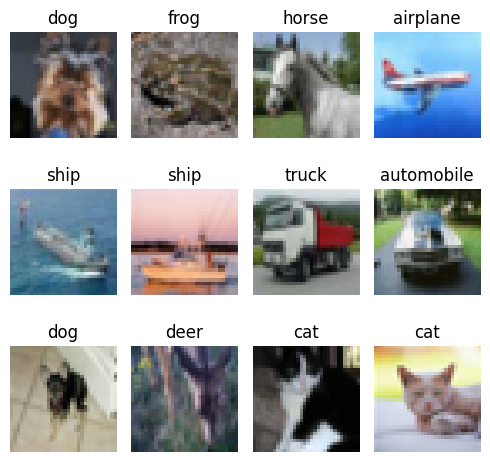

In [ ]:
# Display the images to get a better visual understanding of the dataset

# Number of images to display
num_images_to_display = 12

# Create a random list of indices - to display random images of the dataset each time
random_indices = random.sample(range(len(X_train)), num_images_to_display)

# Create a grid layout for displaying images
rows = 3  # Number of rows of grid
cols = 4  # Number of columns of grid

# Create a figure for the grid
fig, axes = plt.subplots(rows, cols, figsize=(5, 5))

# Loop through the grid and display the images
for i in range(rows):
    for j in range(cols):
        index = random_indices[i * cols + j]
        ax = axes[i, j]
        ax.imshow(X_train[index], cmap=plt.cm.binary)
        ax.axis('off')

        # Get the label for the current image
        label_index = y_train[index, 0]

        ax.set_title(labels[label_index])

plt.tight_layout()
plt.show()

Data Reshaping

In [ ]:
# Reshape the X_train and X_test data to 2D arrays
X_train_2d = X_train.reshape(X_train.shape[0], -1)
X_test_2d = X_test.reshape(X_test.shape[0], -1)

print("New Dimensions of X_train are:",X_train_2d.shape)
print("New Dimensions of X_test are:",X_test_2d.shape)

New Dimensions of X_train are: (50000, 3072)
New Dimensions of X_test are: (10000, 3072)


Data Normalization

In [ ]:
# We know that the pixels in each image is between no colour and full color and thus [0,255]
def normalization_pixels(train, test):
 # convert from integers to floats
 train_norm = train.astype('float32')
 test_norm = test.astype('float32')
 # normalize to range 0-1
 train_norm = train_norm / 255.0
 test_norm = test_norm / 255.0
 # return normalized images
 return train_norm, test_norm

X_train_2d_norm, X_test_2d_norm = normalization_pixels(X_train_2d,X_test_2d)

Reconstruction with PCA

In [ ]:
def pca_reconstruction(X_train, X_test, n_components):

  print("Before PCA Dimensions of X train:", X_train.shape)
  print("Before PCA Dimensions of X test:", X_test.shape)

  # Initialize Principal Component Analysis Object
  pca = PCA(n_components=n_components,svd_solver='auto',tol=0.0,random_state=None)

  # Fitting and Transforming the training and the testing to reduce the dimensionality of both datasets
  start_training_time = time.time()
  X_train_pca = pca.fit_transform(X_train)
  end_training_time = time.time()
  training_time = end_training_time - start_training_time

  X_test_pca = pca.transform(X_test)

  print("After PCA Dimensions of X train:", X_train_pca.shape)
  print("After PCA Dimensions of X test:", X_test_pca.shape)

  # Reconstruct the data
  start_reconstruction_time = time.time()
  X_train_reconstructed = pca.inverse_transform(X_train_pca)
  end_reconstruction_time = time.time()
  reconstruction_time = end_reconstruction_time - start_reconstruction_time
  X_test_reconstructed = pca.inverse_transform(X_test_pca)

  print("Reconstructed Dimensions of X train:", X_train_reconstructed.shape)
  print("Reconstructed Dimensions of X test:", X_test_reconstructed.shape)
  print(f"Training Time: {training_time}")
  print(f"Reconstruction Time: {reconstruction_time}")
  return X_train_reconstructed, X_test_reconstructed, training_time, reconstruction_time

Perform PCA and reconstruct Input

In [ ]:
X_train_reconstructed, X_test_reconstructed, training_time, reconstruction_time  = pca_reconstruction(X_train_2d_norm, X_test_2d_norm, 0.95) # PCA reconstruction keeping 95% of input variance

Before PCA Dimensions of X train: (50000, 3072)
Before PCA Dimensions of X test: (10000, 3072)
After PCA Dimensions of X train: (50000, 217)
After PCA Dimensions of X test: (10000, 217)
Reconstructed Dimensions of X train: (50000, 3072)
Reconstructed Dimensions of X test: (10000, 3072)
Training Time: 74.80935978889465
Reconstruction Time: 1.7368953227996826


Functions for Reconstruction Metrics Calculation

In [ ]:
# Fuction for MSE and RMSE Calculation
def mse_rmse_calculation(data_1, data_2, string):
    mse = np.square(np.subtract(data_1, data_2)).mean()
    rmse = np.sqrt(mse)

    # Display the results
    print(f'Metrics of {string}:')
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")

    return mse,rmse

In [ ]:
# Rescaling and Tranforming Reconstructed Data to the Initial Format
def tranform_reconstruction_to_image_scale(data):
  data = data * 255.0
  data = data.astype('uint8')
  data = data.reshape(data.shape[0],32,32,3)
  return data

In [ ]:
# Function for calculation of Structural Similarity Index
def ssim_calculation(X, X_reconstructed, string):

  ssim_values = []

  for original_image, recostructed_image in zip(X, X_reconstructed):
      ssim_value = structural_similarity(original_image, recostructed_image, channel_axis = -1)
      ssim_values.append(ssim_value)

  # Taking the average SSI over all images
  average_ssim = np.mean(ssim_values)

  print(f"Average Structural Similarity Index (SSIM) in {string}: {average_ssim}")

  return average_ssim

Reconstruct Data

In [ ]:
# Reconstructing Images
X_train_reconstructed_images = tranform_reconstruction_to_image_scale(X_train_reconstructed)
X_test_reconstructed_images = tranform_reconstruction_to_image_scale(X_test_reconstructed)

In [ ]:
# Calculating and Printing Metrics
# SSIM
ssim_train = ssim_calculation(X_train, X_train_reconstructed_images, 'Training Set')
ssim_test = ssim_calculation(X_test, X_test_reconstructed_images, 'Test Set')
# MSE - RMSE in Original Scale
mse_rmse_calculation(X_train, X_train_reconstructed_images , 'Training Set')
mse_rmse_calculation(X_test, X_test_reconstructed_images , 'Test Set')
# MSE - RMSE
mse_rmse_calculation(X_train_2d_norm, X_train_reconstructed, 'Training Set (Normalized)')
mse_rmse_calculation(X_test_2d_norm, X_test_reconstructed, 'Test Set (Normalized)')

Average Structural Similarity Index (SSIM) in Training Set: 0.7951795179047147
Average Structural Similarity Index (SSIM) in Test Set: 0.795409536027385
Metrics of Training Set:
Mean Squared Error (MSE): 62.558283958333334
Root Mean Squared Error (RMSE): 7.90937949262351
Metrics of Test Set:
Mean Squared Error (MSE): 62.770151302083335
Root Mean Squared Error (RMSE): 7.922761595686401
Metrics of Training Set (Normalized):
Mean Squared Error (MSE): 0.003084480995312333
Root Mean Squared Error (RMSE): 0.055538102984428406
Metrics of Test Set (Normalized):
Mean Squared Error (MSE): 0.0031281872652471066
Root Mean Squared Error (RMSE): 0.05593020096421242


(0.0031281873, 0.0559302)

Data Visualization

In [ ]:
# Function to plot original vs reconstructed images
def visualize_images(original, reconstructed, string, num_samples=5):
    plt.figure(figsize=(12, 6))

    for i in range(num_samples):
        # Original Image
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(original[i])
        plt.title(f'Original #{i+1}', fontsize=12)
        plt.axis('off')

        # Reconstructed Image
        plt.subplot(2, num_samples, i + 1 + num_samples)
        plt.imshow(reconstructed[i])
        plt.title(f'{string} #{i+1}', fontsize=12)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

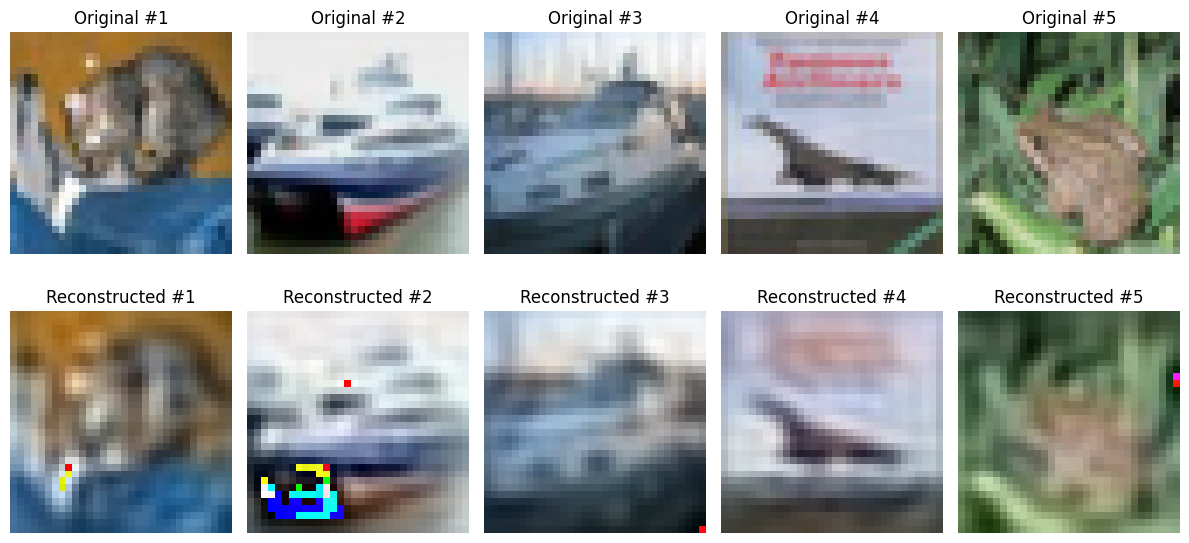

In [ ]:
# Visualize some images
visualize_images(X_test, X_test_reconstructed_images,"Reconstructed")

We can see that the reconstructed images are lower in quality, more blure and contain some pixels with abnormal coloring. However, the general patterns and reconstruction is performed correctly and with relative accuracy, something that can be assessed by the metrics calculated.

## **PCA Reconstruction Exploration**

Now, I will check how the reconstruction error varies with the percentage of variance selected to be kept during Principal Component Analysis.

------Percentage of Variance Kept:0.2------
Before PCA Dimensions of X train: (50000, 3072)
Before PCA Dimensions of X test: (10000, 3072)
After PCA Dimensions of X train: (50000, 1)
After PCA Dimensions of X test: (10000, 1)
Reconstructed Dimensions of X train: (50000, 3072)
Reconstructed Dimensions of X test: (10000, 3072)
Training Time: 71.39008474349976
Reconstruction Time: 1703942156.9379625
Average Structural Similarity Index (SSIM) in Test Set: 0.1416933711728811
Metrics of Test Set:
Mean Squared Error (MSE): 104.90288313802084
Root Mean Squared Error (RMSE): 10.242210852058301
------Percentage of Variance Kept:0.5------
Before PCA Dimensions of X train: (50000, 3072)
Before PCA Dimensions of X test: (10000, 3072)
After PCA Dimensions of X train: (50000, 4)
After PCA Dimensions of X test: (10000, 4)
Reconstructed Dimensions of X train: (50000, 3072)
Reconstructed Dimensions of X test: (10000, 3072)
Training Time: 73.38036179542542
Reconstruction Time: 1703942243.0125604
Average 

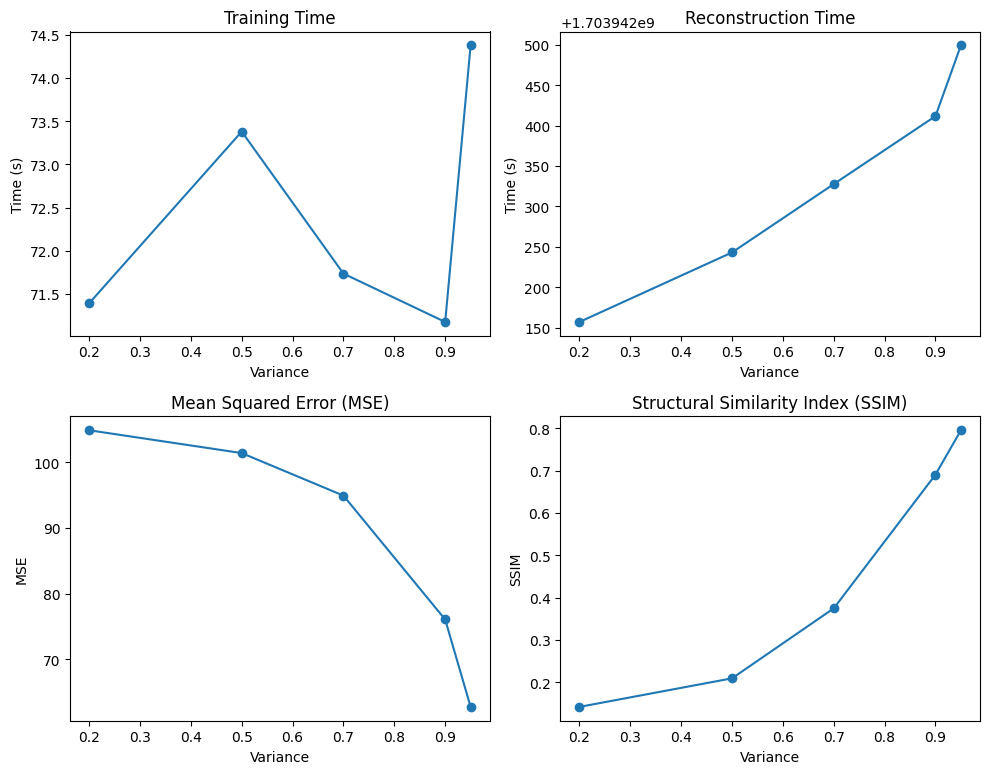

In [ ]:
variance_percentage = [0.2,0.5,0.7,0.9,0.95]
training_time_list = []
reconstruction_time_list = []
mse_list = []
ssim_list = []

# Loop to run though the specified list and reconstruct the input images using different percentage of variances
for variance in variance_percentage:
  print(f'------Percentage of Variance Kept:{variance}------')
  x_train_reconstructed, x_test_reconstructed, training_time, reconstruction_time  = pca_reconstruction(X_train_2d_norm, X_test_2d_norm, variance)
  x_train_reconstructed_images = tranform_reconstruction_to_image_scale(x_train_reconstructed)
  x_test_reconstructed_images = tranform_reconstruction_to_image_scale(x_test_reconstructed)
  ssim_test = ssim_calculation(X_test, x_test_reconstructed_images, 'Test Set')
  mse,rmse = mse_rmse_calculation(X_test, x_test_reconstructed_images, 'Test Set')

  training_time_list.append(training_time)
  reconstruction_time_list.append(reconstruction_time)
  mse_list.append(mse)
  ssim_list.append(ssim_test)

# Plotting the results

# Create a 2x2 figure array
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Plot Training Time
axs[0, 0].plot(variance_percentage, training_time_list, marker='o')
axs[0, 0].set_title('Training Time')
axs[0, 0].set_xlabel('Variance')
axs[0, 0].set_ylabel('Time (s)')

# Plot Reconstruction Time
axs[0, 1].plot(variance_percentage, reconstruction_time_list, marker='o')
axs[0, 1].set_title('Reconstruction Time')
axs[0, 1].set_xlabel('Variance')
axs[0, 1].set_ylabel('Time (s)')

# Plot Mean Squared Error (MSE)
axs[1, 0].plot(variance_percentage, mse_list, marker='o')
axs[1, 0].set_title('Mean Squared Error (MSE)')
axs[1, 0].set_xlabel('Variance')
axs[1, 0].set_ylabel('MSE')

# Plot Structural Similarity Index (SSIM)
axs[1, 1].plot(variance_percentage, ssim_list, marker='o')
axs[1, 1].set_title('Structural Similarity Index (SSIM)')
axs[1, 1].set_xlabel('Variance')
axs[1, 1].set_ylabel('SSIM')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

------Number of Features Kept:128------
Before PCA Dimensions of X train: (50000, 3072)
Before PCA Dimensions of X test: (10000, 3072)
After PCA Dimensions of X train: (50000, 128)
After PCA Dimensions of X test: (10000, 128)
Reconstructed Dimensions of X train: (50000, 3072)
Reconstructed Dimensions of X test: (10000, 3072)
Training Time: 19.808448791503906
Reconstruction Time: 0.8026442527770996
Average Structural Similarity Index (SSIM) in Test Set: 0.7276581773937387
Metrics of Test Set:
Mean Squared Error (MSE): 0.0050836061127483845
Root Mean Squared Error (RMSE): 0.07129941135644913
------Number of Features Kept:256------
Before PCA Dimensions of X train: (50000, 3072)
Before PCA Dimensions of X test: (10000, 3072)
After PCA Dimensions of X train: (50000, 256)
After PCA Dimensions of X test: (10000, 256)
Reconstructed Dimensions of X train: (50000, 3072)
Reconstructed Dimensions of X test: (10000, 3072)
Training Time: 21.010666370391846
Reconstruction Time: 1.3336021900177002
Av

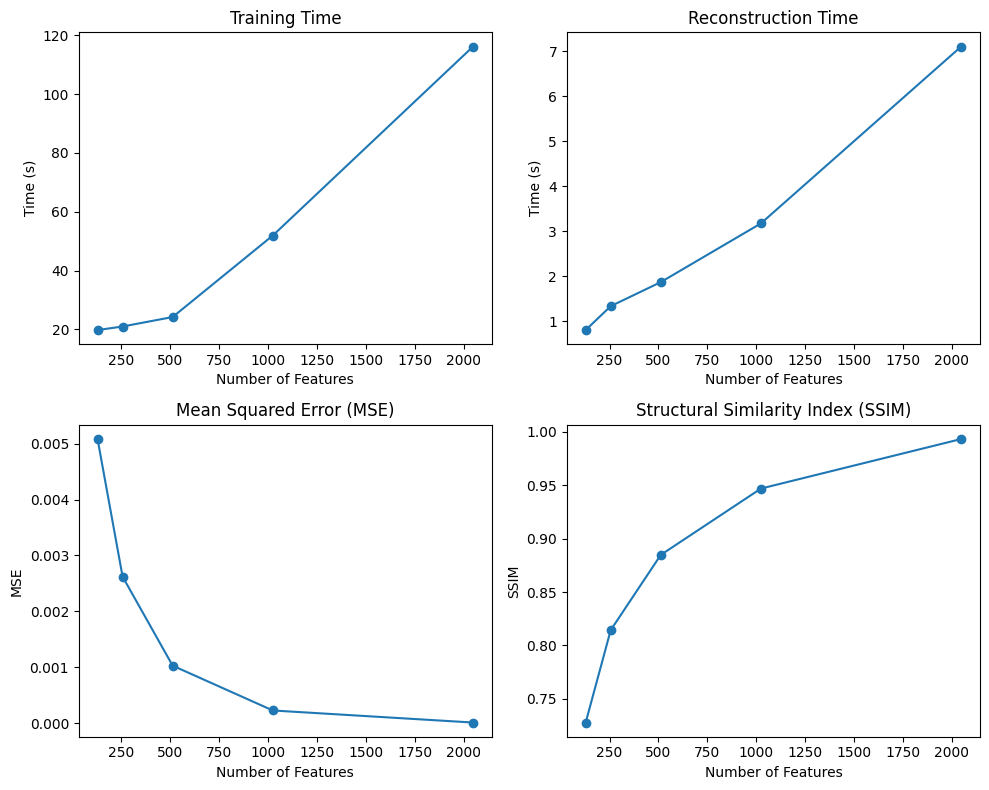

In [ ]:
number_of_features_to_keep = [128,256,512,1024,2048]
training_time_list = []
reconstruction_time_list = []
mse_list = []
ssim_list = []

# Loop to reconstruct the input images using different numbers of features
for num_feautures in number_of_features_to_keep:
  print(f'------Number of Features Kept:{num_feautures}------')
  x_train_reconstructed, x_test_reconstructed, training_time, reconstruction_time  = pca_reconstruction(X_train_2d_norm, X_test_2d_norm, num_feautures)
  x_train_reconstructed_images = tranform_reconstruction_to_image_scale(x_train_reconstructed)
  x_test_reconstructed_images = tranform_reconstruction_to_image_scale(x_test_reconstructed)
  ssim_test = ssim_calculation(X_test, x_test_reconstructed_images, 'Test Set')
  mse,rmse = mse_rmse_calculation(X_test_2d_norm, x_test_reconstructed, 'Test Set')

  training_time_list.append(training_time)
  reconstruction_time_list.append(reconstruction_time)
  mse_list.append(mse)
  ssim_list.append(ssim_test)

# Plotting the results

# Create a 2x2 figure array
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Plot Training Time
axs[0, 0].plot(number_of_features_to_keep, training_time_list, marker='o')
axs[0, 0].set_title('Training Time')
axs[0, 0].set_xlabel('Number of Features')
axs[0, 0].set_ylabel('Time (s)')

# Plot Reconstruction Time
axs[0, 1].plot(number_of_features_to_keep, reconstruction_time_list, marker='o')
axs[0, 1].set_title('Reconstruction Time')
axs[0, 1].set_xlabel('Number of Features')
axs[0, 1].set_ylabel('Time (s)')

# Plot Mean Squared Error (MSE)
axs[1, 0].plot(number_of_features_to_keep, mse_list, marker='o')
axs[1, 0].set_title('Mean Squared Error (MSE)')
axs[1, 0].set_xlabel('Number of Features')
axs[1, 0].set_ylabel('MSE')

# Plot Structural Similarity Index (SSIM)
axs[1, 1].plot(number_of_features_to_keep, ssim_list, marker='o')
axs[1, 1].set_title('Structural Similarity Index (SSIM)')
axs[1, 1].set_xlabel('Number of Features')
axs[1, 1].set_ylabel('SSIM')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# **Reconstruct Input with AutoEncoders**

*Desciption of the approach to AutoEncoders' Architecture*

**Encoder**

The encoder consists of layers that focus on reducing the spatial dimensions by applying various filters. These layers try to extract meaningful features from the data, and reduce the variables needed to explain them.

**Latent Vector - Bottleneck**
Between the encoder and decoder is the bottleneck whose mission is to represent the input data in different vector representation - many times in reduced dimensions.

**Decoder**

The decoder Layers generally mirrors the encoder layers in reverse order, in order to gradually increase the spatial dimensions, reduce the number of filters and reconstruct the initial image, while trying to minimize the reconstruction loss.

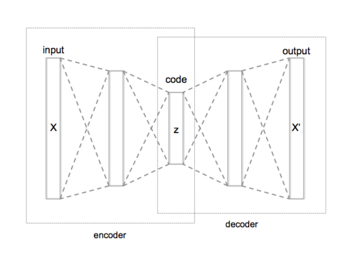


In [ ]:
X_train_norm, X_test_norm = normalization_pixels(X_train,X_test) # Data Normalization to help the NNs learn and converge faster

In [ ]:
# Early Stopping for the training process
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

## **Basic AutoEncoder Models**

**Basic Model**

In [ ]:
# Basic Autoencoder Model with Convolutional Layers

inputs = keras.layers.Input(shape=(32, 32, 3), name="input")

# Encoder
x = keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same', name='Conv2D_1')(inputs)
x = keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same', name='MaxPool_1')(x)

# Bottleneck
bottle_neck = keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same', name='Bottle_neck')(x)

# Decoder
x = keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same', name='Conv2D_2')(bottle_neck)
x = keras.layers.UpSampling2D(size=(2, 2), name='UpSample_1')(x)

outputs = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same', name='output')(x)

basic_autoencoder = keras.Model(inputs, outputs, name = "Base_Model") # specifying the autoencoder
basic_encoder = keras.Model(inputs = inputs, outputs = bottle_neck, name = "Base_Model_Encoder") # specifying the encoder
# Compiling
basic_autoencoder.compile(optimizer='adam', metrics=['accuracy'], loss='mean_squared_error')
# Printing the resulted architecture
basic_autoencoder.summary()

Model: "Base_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 32, 32, 3)]       0         
                                                                 
 Conv2D_1 (Conv2D)           (None, 32, 32, 8)         224       
                                                                 
 MaxPool_1 (MaxPooling2D)    (None, 16, 16, 8)         0         
                                                                 
 Bottle_neck (Conv2D)        (None, 16, 16, 16)        1168      
                                                                 
 Conv2D_2 (Conv2D)           (None, 16, 16, 8)         1160      
                                                                 
 UpSample_1 (UpSampling2D)   (None, 32, 32, 8)         0         
                                                                 
 output (Conv2D)             (None, 32, 32, 3)         2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 8.3 MB/s eta 0:00:00


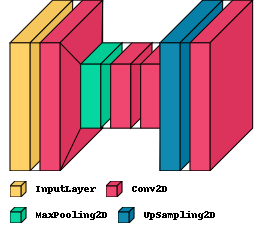

In [ ]:
!pip install visualkeras
import visualkeras
# better visualization with visualkeras
visualkeras.layered_view(basic_autoencoder,legend=True)

In [ ]:
# Calculating training time and fitting the autoencoder

training_time_start = time.time()
history = basic_autoencoder.fit(X_train_norm, X_train_norm, steps_per_epoch =(50000//128), validation_steps =(10000//128) ,validation_data = (X_test_norm,X_test_norm), batch_size=128, shuffle=True, epochs = 50, callbacks=[early_stopping],verbose=0)
training_time_end = time.time()
print(f"Training Time: {training_time_end - training_time_start}")
encoded_images_test = basic_encoder.predict(X_test_norm)
print('Encoded Images Dimensions:', encoded_images_test.shape)
reconstructed_images_test = basic_autoencoder.predict(X_test_norm)
print('Decoded Images Dimensions:', reconstructed_images_test.shape)

# Using Encoder and Autoencoder for predictions
encoded_images_train = basic_encoder.predict(X_train_norm)
reconstructed_images_train = basic_autoencoder.predict(X_train_norm)

# Metrics Calculation
ssim_train = ssim_calculation(X_train_norm, reconstructed_images_train, 'Training Set')
ssim_test = ssim_calculation(X_test_norm, reconstructed_images_test, 'Test Set')
mse_rmse_calculation(X_train_norm, reconstructed_images_train, 'Training Set')
mse_rmse_calculation(X_test_norm, reconstructed_images_test, 'Test Set')

Training Time: 117.26463150978088
313/313 [==============================] - 2s 4ms/step
Encoded Images Dimensions: (10000, 16, 16, 16)
313/313 [==============================] - 1s 2ms/step
Decoded Images Dimensions: (10000, 32, 32, 3)
1563/1563 [==============================] - 3s 2ms/step
Average Structural Similarity Index (SSIM) in Training Set: 0.9626196026802063
Average Structural Similarity Index (SSIM) in Test Set: 0.962681233882904
Metrics of Training Set:
Mean Squared Error (MSE): 0.0012263946700841188
Root Mean Squared Error (RMSE): 0.03501991927623749
Metrics of Test Set:
Mean Squared Error (MSE): 0.0012235438916832209
Root Mean Squared Error (RMSE): 0.034979190677404404


(0.0012235439, 0.03497919)

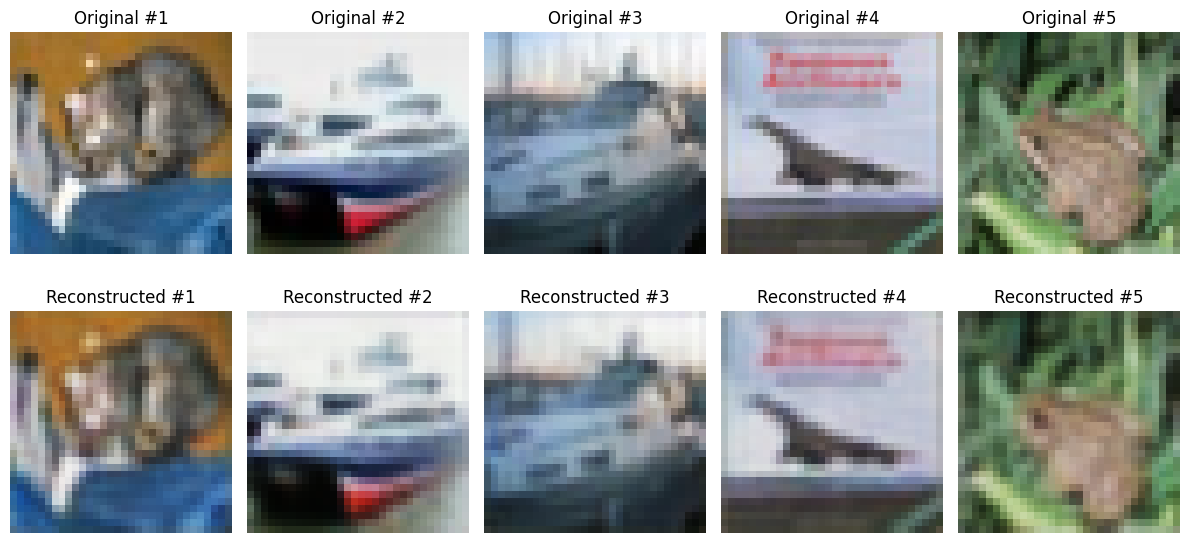

In [ ]:
# Visualizing Reconstructed images vs original
visualize_images(X_test_norm,reconstructed_images_test,"Reconstructed")

We can see that the SSIM is over 95%, and the images are almost identical. However, even this model is small, the latent vector after the encoder is very large, and thus their is not significant dimensionality reduction.

**Basic AutoEncoder - Bigger Dimensionality Reduction**

In [ ]:
# Creating a Similar Architecture, but performing dimensionality reduction by changing the parameters of the MaxPooling2D Layer

inputs = keras.layers.Input(shape=(32, 32, 3), name="input")

# Encoder
x = keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same', name='Conv2D_1')(inputs)
x = keras.layers.MaxPooling2D(pool_size=(4, 4), padding='same', name='MaxPool_1')(x)

# Bottleneck
bottle_neck = keras.layers.Conv2D(3, (3, 3), activation='relu', padding='same', name='Bottle_neck')(x)

# Decoder
x = keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same', name='Conv2D_2')(bottle_neck)
x = keras.layers.UpSampling2D(size=(4, 4), name='UpSample_1')(x)

outputs = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same', name='output')(x)

basic_autoencoder = keras.Model(inputs, outputs, name = "Base_Model_2")
basic_encoder = keras.Model(inputs = inputs, outputs = bottle_neck, name = "Base_Model_Encoder")
basic_autoencoder.compile(optimizer='adam', metrics=['accuracy'], loss='mean_squared_error')

basic_autoencoder.summary()

Model: "Base_Model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 32, 32, 3)]       0         
                                                                 
 Conv2D_1 (Conv2D)           (None, 32, 32, 8)         224       
                                                                 
 MaxPool_1 (MaxPooling2D)    (None, 8, 8, 8)           0         
                                                                 
 Bottle_neck (Conv2D)        (None, 8, 8, 3)           219       
                                                                 
 Conv2D_2 (Conv2D)           (None, 8, 8, 8)           224       
                                                                 
 UpSample_1 (UpSampling2D)   (None, 32, 32, 8)         0         
                                                                 
 output (Conv2D)             (None, 32, 32, 3)        

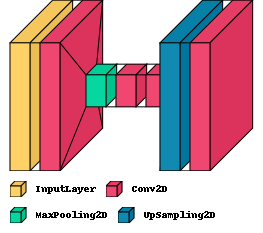

In [ ]:
visualkeras.layered_view(basic_autoencoder,legend=True)

In [ ]:
# Training Time and Metrics Calculation

training_time_start = time.time()
history = basic_autoencoder.fit(X_train_norm, X_train_norm, steps_per_epoch =(50000//128), validation_steps =(10000//128) ,validation_data = (X_test_norm,X_test_norm), batch_size=128, shuffle=True, epochs = 50, callbacks=[early_stopping],verbose=0)
training_time_end = time.time()
print(f"Training Time: {training_time_end - training_time_start}")
encoded_images_test = basic_encoder.predict(X_test_norm)
print('Encoded Images Dimensions:', encoded_images_test.shape)
reconstructed_images_test = basic_autoencoder.predict(X_test_norm)
print('Decoded Images Dimensions:', reconstructed_images_test.shape)

encoded_images_train = basic_encoder.predict(X_train_norm)
reconstructed_images_train = basic_autoencoder.predict(X_train_norm)
ssim_train = ssim_calculation(X_train_norm, reconstructed_images_train, 'Training Set')
ssim_test = ssim_calculation(X_test_norm, reconstructed_images_test, 'Test Set')

mse_rmse_calculation(X_train_norm, reconstructed_images_train, 'Training Set')
mse_rmse_calculation(X_test_norm, reconstructed_images_test, 'Test Set')

Training Time: 109.3718810081482
313/313 [==============================] - 1s 2ms/step
Encoded Images Dimensions: (10000, 8, 8, 3)
313/313 [==============================] - 1s 2ms/step
Decoded Images Dimensions: (10000, 32, 32, 3)
1563/1563 [==============================] - 3s 2ms/step
Average Structural Similarity Index (SSIM) in Training Set: 0.7459481954574585
Average Structural Similarity Index (SSIM) in Test Set: 0.7461438179016113
Metrics of Training Set:
Mean Squared Error (MSE): 0.008274408057332039
Root Mean Squared Error (RMSE): 0.09096377342939377
Metrics of Test Set:
Mean Squared Error (MSE): 0.00827671680599451
Root Mean Squared Error (RMSE): 0.09097646176815033


(0.008276717, 0.09097646)

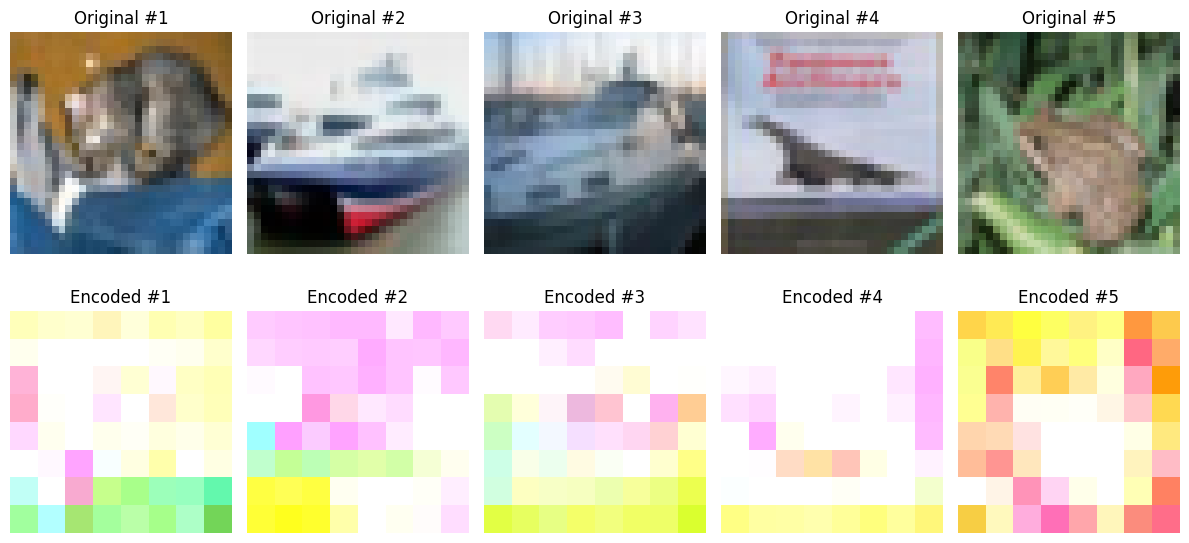

In [ ]:
# Visualization of Original vs Encoded Labels
visualize_images(X_test, encoded_images_test,"Encoded")

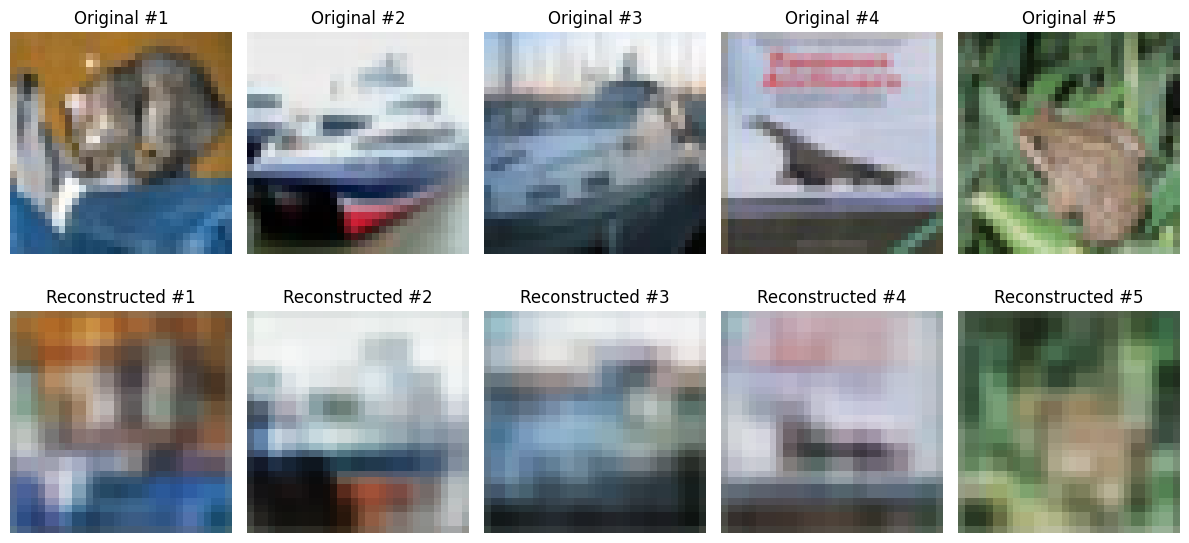

In [ ]:
# Original vs Reconstructed Images
visualize_images(X_test_norm,reconstructed_images_test,"Reconstructed")

The SSIM now is small around 75%. The images now are not identical. The general pattern is kept as well as not very specific details. However, the images are blur. The dimensionality reduction is pretty big as the original image (32,32,3) is (8,8,3). These dimensions also enable the display of the images as well in the encoded form.

**Simple Autoencoders without Convolutional Layers**

In [ ]:
# Creating Architectures without Convolution Layers, but using Dense layers.
# We expect the Conv2D layers to have a greater result.

# Define the autoencoder architecture
input_shape = (32, 32, 3)
input_img = keras.layers.Input(shape=input_shape, name="input")

# Flatten the input image
flat_input = keras.layers.Flatten()(input_img)

# Encoder
encoded = keras.layers.Dense(256, activation='relu', name='Encoder_Dense_1')(flat_input)
encoded = keras.layers.Dense(128, activation='relu', name='Encoder_Dense_2')(encoded)

# Decoder
decoded = keras.layers.Dense(256, activation='relu', name='Decoder_Dense_1')(encoded)
decoded = keras.layers.Dense(np.prod(input_shape), activation='sigmoid', name='Decoder_Dense_2')(decoded)

# Reshape the output to the original image shape
decoded_img = keras.layers.Reshape(input_shape)(decoded)

dense_autoencoder = keras.models.Model(input_img, decoded_img, name="Dense_Autoencoder")

# Compile the autoencoder
dense_autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

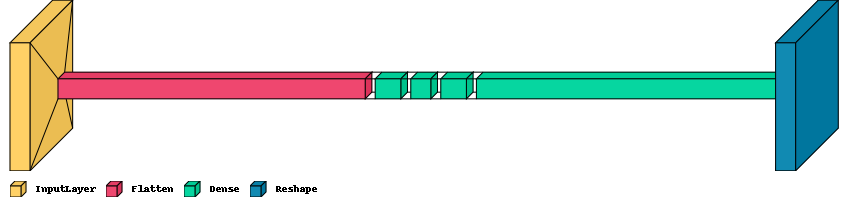

In [ ]:
visualkeras.layered_view(dense_autoencoder,legend=True)

In [ ]:
# Calculation of training time and reconstruction time

training_time_start = time.time()
history = dense_autoencoder.fit(X_train_norm, X_train_norm, steps_per_epoch =(50000//128), validation_steps =(10000//128) ,validation_data = (X_test_norm,X_test_norm), batch_size=128, shuffle=True, epochs = 50, callbacks=[early_stopping],verbose=0)
training_time_end = time.time()
print(f"Training Time: {training_time_end - training_time_start}")
reconstructed_images_test = dense_autoencoder.predict(X_test_norm)
print('Decoded Images Dimensions:', reconstructed_images_test.shape)

reconstructed_images_train = dense_autoencoder.predict(X_train_norm)
ssim_train = ssim_calculation(X_train_norm, reconstructed_images_train, 'Training Set')
ssim_test = ssim_calculation(X_test_norm, reconstructed_images_test, 'Test Set')

mse_rmse_calculation(X_train_norm, reconstructed_images_train, 'Training Set')
mse_rmse_calculation(X_test_norm, reconstructed_images_test, 'Test Set')

Training Time: 14.427345514297485
313/313 [==============================] - 1s 2ms/step
Decoded Images Dimensions: (10000, 32, 32, 3)
1563/1563 [==============================] - 3s 2ms/step
Average Structural Similarity Index (SSIM) in Training Set: 0.738526463508606
Average Structural Similarity Index (SSIM) in Test Set: 0.7373579144477844
Metrics of Training Set:
Mean Squared Error (MSE): 0.008303208276629448
Root Mean Squared Error (RMSE): 0.09112194180488586
Metrics of Test Set:
Mean Squared Error (MSE): 0.008366593159735203
Root Mean Squared Error (RMSE): 0.09146908670663834


(0.008366593, 0.09146909)

In [ ]:
# Increasing the parameters of the last Dense Layer to check if more bottleneck features will enhance reconstruction accuracy.

# Define the autoencoder architecture
input_shape = (32, 32, 3)
input_img = keras.layers.Input(shape=input_shape, name="input")

# Flatten the input image
flat_input = keras.layers.Flatten()(input_img)

# Encoder
encoded = keras.layers.Dense(256, activation='relu', name='Encoder_Dense_1')(flat_input)
encoded = keras.layers.Dense(256, activation='relu', name='Encoder_Dense_2')(encoded)

# Decoder
decoded = keras.layers.Dense(256, activation='relu', name='Decoder_Dense_1')(encoded)
decoded = keras.layers.Dense(np.prod(input_shape), activation='sigmoid', name='Decoder_Dense_2')(decoded)

# Reshape the output to the original image shape
decoded_img = keras.layers.Reshape(input_shape)(decoded)

dense_autoencoder = keras.models.Model(input_img, decoded_img, name="Dense_Autoencoder")

# Compile the autoencoder
dense_autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [ ]:
# Calculating Training Time and Metrics
training_time_start = time.time()
history = dense_autoencoder.fit(X_train_norm, X_train_norm, steps_per_epoch =(50000//128), validation_steps =(10000//128) ,validation_data = (X_test_norm,X_test_norm), batch_size=128, shuffle=True, epochs = 50, callbacks=[early_stopping],verbose=0)
training_time_end = time.time()
print(f"Training Time: {training_time_end - training_time_start}")
reconstructed_images_test = dense_autoencoder.predict(X_test_norm)
print('Decoded Images Dimensions:', reconstructed_images_test.shape)

reconstructed_images_train = dense_autoencoder.predict(X_train_norm)
ssim_train = ssim_calculation(X_train_norm, reconstructed_images_train, 'Training Set')
ssim_test = ssim_calculation(X_test_norm, reconstructed_images_test, 'Test Set')

mse_rmse_calculation(X_train_norm, reconstructed_images_train, 'Training Set')
mse_rmse_calculation(X_test_norm, reconstructed_images_test, 'Test Set')

Training Time: 443.51408791542053
313/313 [==============================] - 2s 5ms/step
Decoded Images Dimensions: (10000, 32, 32, 3)
1563/1563 [==============================] - 10s 6ms/step
Average Structural Similarity Index (SSIM) in Training Set: 0.7310709953308105
Average Structural Similarity Index (SSIM) in Test Set: 0.7298741340637207
Metrics of Training Set:
Mean Squared Error (MSE): 0.008574665524065495
Root Mean Squared Error (RMSE): 0.09259948879480362
Metrics of Test Set:
Mean Squared Error (MSE): 0.008636701852083206
Root Mean Squared Error (RMSE): 0.09293385595083237


(0.008636702, 0.092933856)

## **Complex Models - More Layers**

In this section, some more complex models are going to be tested and see how these extra hidden layers can affect the AutoEncoders.

**Complex Model 1**

High Reconstruction Accuracy, Large Bottle Neck Dimensions

In the following cell an optimized AutoEncoder is presented. It is imperative to showcase that apart from the autoencoder, models are created for the encoder and decoder separately with similar to the corresponding AutoEncoder parts. In this way, the encoder and decoder can be utilized separately.

In [ ]:
# Creating more complex Architectures by adding more layers and performing more smooth dimensional reduction.

inputs = keras.layers.Input(shape = (32,32,3),name = "input")

x = keras.layers.Conv2D(32, (3,3), activation = 'relu', padding = 'same', name = 'Conv2D_1')(inputs)
x = keras.layers.MaxPooling2D(pool_size = (2,2), padding = 'same', name = 'MaxPool_1')(x)

x = keras.layers.Conv2D(64,(3,3), activation = 'relu', padding = 'same', name = 'Conv2D_2')(x)
x = keras.layers.MaxPooling2D(pool_size = (2,2), padding = 'same', name = 'MaxPool_2')(x)

x = keras.layers.Conv2D(128,(3,3), activation = 'relu', padding = 'same', name = 'Conv2D_3')(x)
x = keras.layers.MaxPooling2D(pool_size = (2,2), padding = 'same', name = 'MaxPool_3')(x)

# the compressed representation of the input images
bottle_neck = keras.layers.Conv2D(256, (3, 3), activation = 'relu', padding = 'same', name = 'Bottle_neck')(x)
# create a layer to produce a visual representation of the compressed images
# to do so by only using 3 filters it gerenerates visualizations in format similar
# to the original input image
encoder_vis = keras.layers.Conv2D(3, (3, 3), activation = 'relu', padding = 'same', name = 'Encoder_vis')(bottle_neck)

x = keras.layers.Conv2D(128, (3, 3), activation = 'relu', padding = 'same', name = 'Conv2D_4')(bottle_neck)
x = keras.layers.UpSampling2D(size = (2, 2), name = 'UpSample_1')(x)

x = keras.layers.Conv2D(64, (3, 3), activation = 'relu', padding = 'same', name = 'Conv2D_5')(x)
x = keras.layers.UpSampling2D(size = (2, 2), name = 'UpSample_2')(x)

x = keras.layers.Conv2D(32, (3, 3), activation = 'relu', padding = 'same', name = 'Conv2D_6')(x)
x = keras.layers.UpSampling2D(size = (2, 2), name = 'UpSample_3')(x)

outputs = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding = 'same', name = 'output')(x)

autoencoder = keras.Model(inputs, outputs, name = "Model_1")

autoencoder.compile(optimizer = 'adam', metrics = ['accuracy'], loss = 'mean_squared_error')

In [ ]:
autoencoder.summary()

Model: "Model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 32, 32, 3)]       0         
                                                                 
 Conv2D_1 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 MaxPool_1 (MaxPooling2D)    (None, 16, 16, 32)        0         
                                                                 
 Conv2D_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 MaxPool_2 (MaxPooling2D)    (None, 8, 8, 64)          0         
                                                                 
 Conv2D_3 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 MaxPool_3 (MaxPooling2D)    (None, 4, 4, 128)         0   

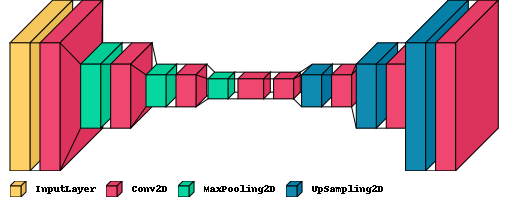

In [ ]:
visualkeras.layered_view(autoencoder,legend=True)

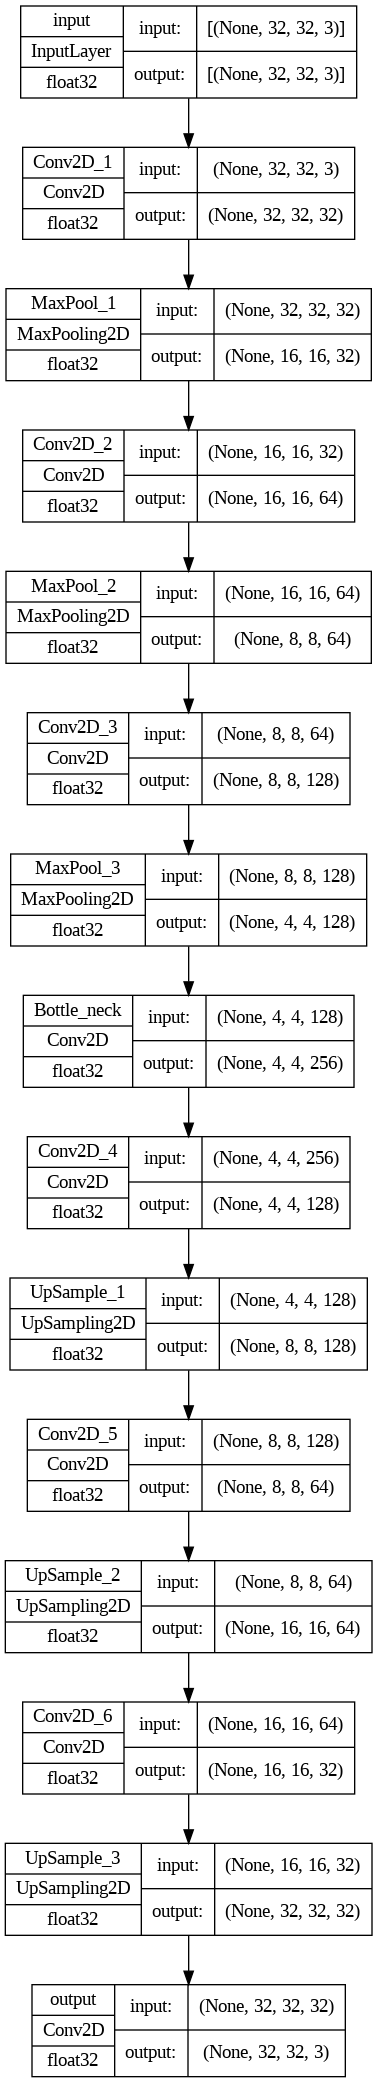

In [ ]:
keras.utils.plot_model(autoencoder, "autoencoder.png", show_shapes = True, show_dtype = True)

In [ ]:
encoder = keras.Model(inputs = inputs, outputs = bottle_neck)

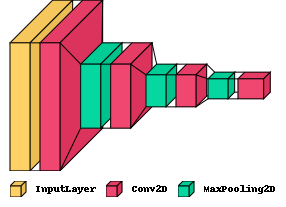

In [ ]:
visualkeras.layered_view(encoder,legend=True)

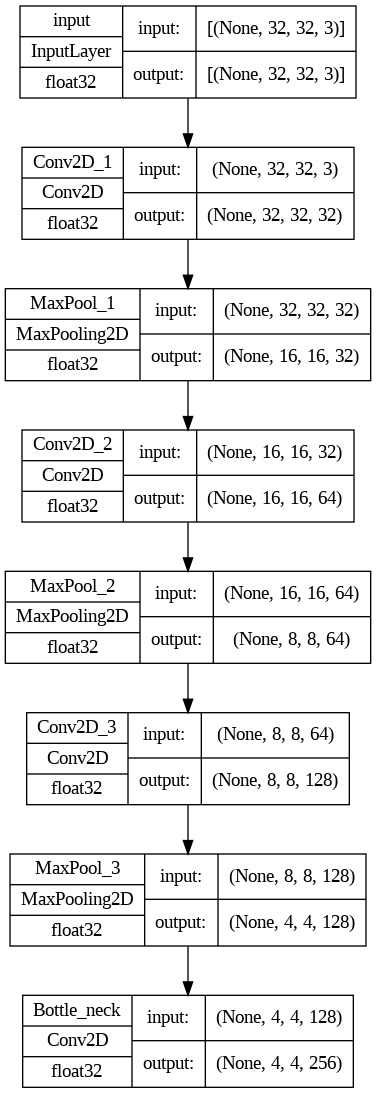

In [ ]:
keras.utils.plot_model(encoder, "encoder.png", show_shapes = True, show_dtype = True)

In [ ]:
decoder = keras.Model(inputs = bottle_neck, outputs = outputs)

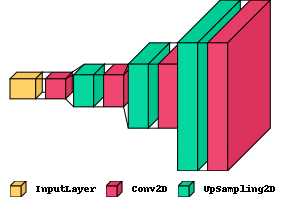

In [ ]:
visualkeras.layered_view(decoder,legend=True)

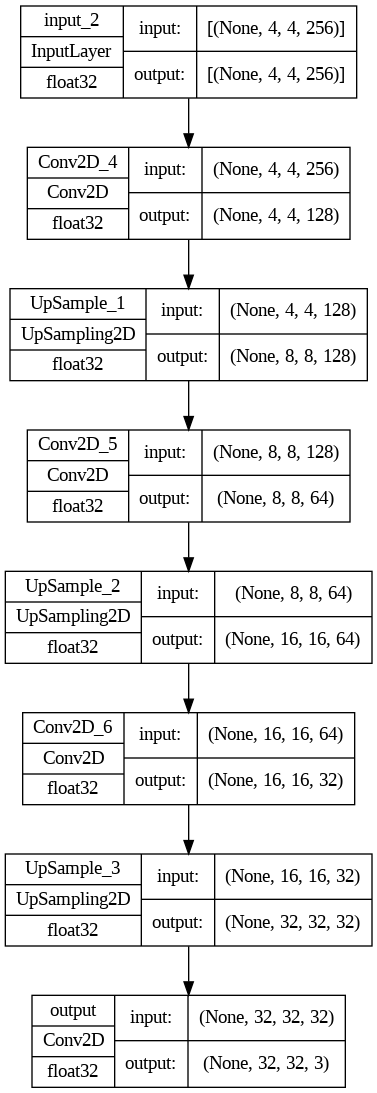

In [ ]:
keras.utils.plot_model(decoder, "decoder.png", show_shapes = True, show_dtype = True)

In [ ]:
training_time_start = time.time()
history = autoencoder.fit(X_train_norm, X_train_norm, steps_per_epoch =(50000//128), validation_steps =(10000//128) ,validation_data = (X_test_norm,X_test_norm), batch_size=128, shuffle=True, epochs = 50, callbacks=[early_stopping])
training_time_end = time.time()
print(f"Training Time: {training_time_end - training_time_start}")

Epoch 1/50
390/390 [==============================] - 14s 17ms/step - loss: 0.0166 - accuracy: 0.6577 - val_loss: 0.0102 - val_accuracy: 0.7270
Epoch 2/50
390/390 [==============================] - 7s 14ms/step - loss: 0.0095 - accuracy: 0.7479 - val_loss: 0.0089 - val_accuracy: 0.7612
Epoch 3/50
390/390 [==============================] - 6s 15ms/step - loss: 0.0080 - accuracy: 0.7546 - val_loss: 0.0075 - val_accuracy: 0.7666
Epoch 4/50
390/390 [==============================] - 6s 14ms/step - loss: 0.0070 - accuracy: 0.7590 - val_loss: 0.0065 - val_accuracy: 0.7715
Epoch 5/50
390/390 [==============================] - 5s 14ms/step - loss: 0.0064 - accuracy: 0.7635 - val_loss: 0.0061 - val_accuracy: 0.7559
Epoch 6/50
390/390 [==============================] - 6s 15ms/step - loss: 0.0059 - accuracy: 0.7655 - val_loss: 0.0057 - val_accuracy: 0.7680
Epoch 7/50
390/390 [==============================] - 5s 14ms/step - loss: 0.0055 - accuracy: 0.7704 - val_loss: 0.0054 - val_accuracy: 0.783

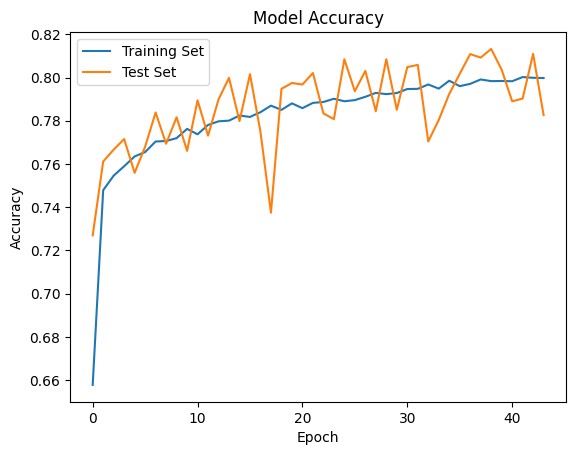

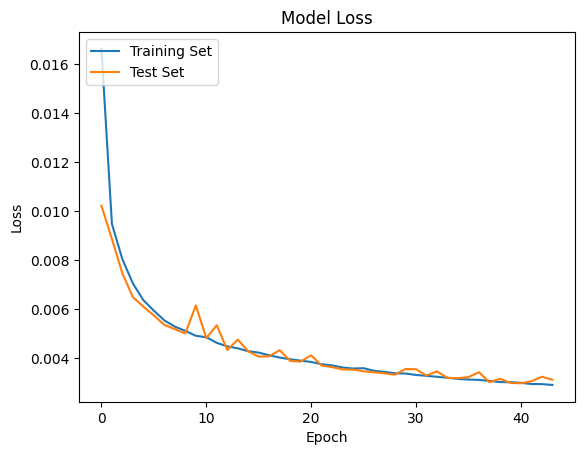

In [ ]:
# summarize history for accuracy
plt.figure(1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Test Set'], loc='upper left')
plt.show()

plt.figure(2)
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Test Set'], loc='upper left')
plt.show()

In [ ]:
result = autoencoder.evaluate(X_train_norm,X_train_norm, steps=50)

50/50 [==============================] - 3s 32ms/step - loss: 0.0029 - accuracy: 0.7889


In [ ]:
encoded_images_test = encoder.predict(X_test_norm)
print('Encoded Images Dimensions:', encoded_images_test.shape)
reconstructed_images_test = autoencoder.predict(X_test_norm)
print('Decoded Images Dimensions:', reconstructed_images_test.shape)

encoded_images_train = encoder.predict(X_train_norm)
reconstructed_images_train = autoencoder.predict(X_train_norm)

313/313 [==============================] - 2s 3ms/step
Encoded Images Dimensions: (10000, 4, 4, 256)
313/313 [==============================] - 1s 3ms/step
Decoded Images Dimensions: (10000, 32, 32, 3)
1563/1563 [==============================] - 4s 3ms/step


In [ ]:
# Reconstruction Metrics
ssim_train = ssim_calculation(X_train_norm, reconstructed_images_train, 'Training Set')
ssim_test = ssim_calculation(X_test_norm, reconstructed_images_test, 'Test Set')

mse_rmse_calculation(X_train_norm, reconstructed_images_train, 'Training Set')
mse_rmse_calculation(X_test_norm, reconstructed_images_test, 'Test Set')

Average Structural Similarity Index (SSIM) in Training Set: 0.8961564302444458
Average Structural Similarity Index (SSIM) in Test Set: 0.8936741948127747
Metrics of Training Set:
Mean Squared Error (MSE): 0.002872426761314273
Root Mean Squared Error (RMSE): 0.05359502509236336
Metrics of Test Set:
Mean Squared Error (MSE): 0.0029665532056242228
Root Mean Squared Error (RMSE): 0.05446607246994972


(0.0029665532, 0.054466072)

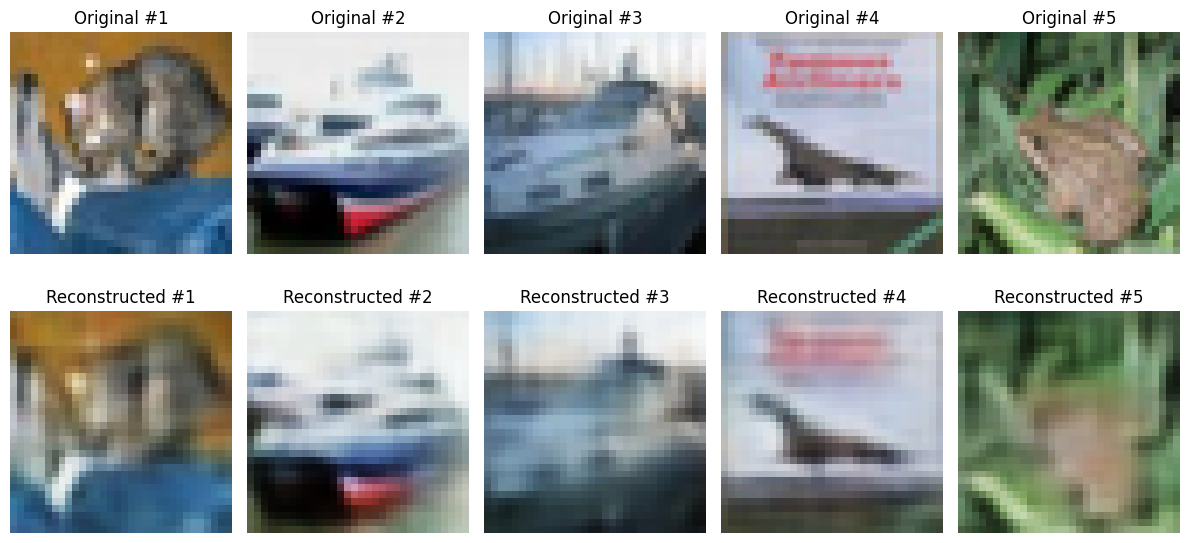

In [ ]:
visualize_images(X_test_norm, reconstructed_images_test,"Reconstructed")

In [ ]:
# In this cell I will try to visualize the intemediate compressed output of the AutoEncoder
# for further understanding of its functionalities.
# Creating a Model for Visualization only
encoder_vis_model = keras.Model(inputs=autoencoder.input, outputs=encoder_vis)
# Predict the encoder visualization for the sample image
encoder_vis_output = encoder_vis_model.predict(X_test_norm)
print("Created custom visualization model with output:",encoder_vis_output[0].shape)

313/313 [==============================] - 1s 2ms/step
Created custom visualization model with output: (4, 4, 3)


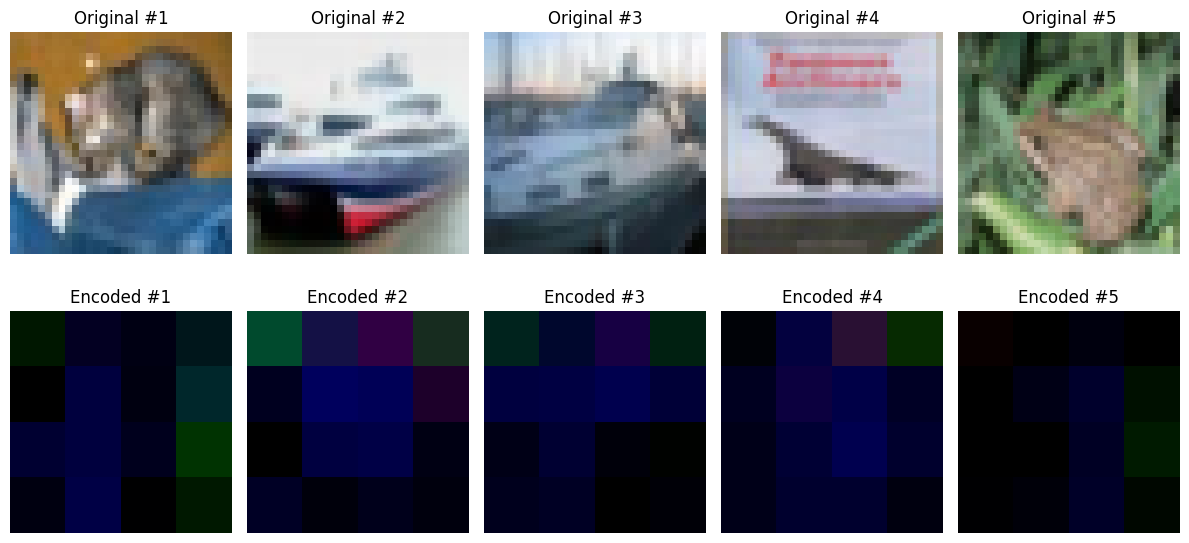

In [ ]:
visualize_images(X_test_norm, encoder_vis_output,"Encoded")





We can see that the Model 1 has reconstructed the input images with higher reconstruction metrics and the reconstructed images are free of those metrics that showcases abnormal colouring.

However, the dimensions of the bottleneck (4,4,256) showcase that there is a high number of channels. We need to explore what will happen if we try perform better job at reducing the dimensions of the input data into the encoded images.

**Complex Model 2**

Better Dimensionality Reduction

In [ ]:
# Since the previous model did not perform Dimensional Reduction of the Input Images in the encoded representation,
# I alter the parameters to see the results.

inputs = keras.layers.Input(shape = (32,32,3), name = 'Input')

x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name = 'Conv2D_1') (inputs)
x = keras.layers.MaxPooling2D(pool_size = (2, 2), name = 'MaxPool_1') (x)

x = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', name = 'Conv2D_2') (x)
x = keras.layers.MaxPooling2D(pool_size = (2, 2), name = 'MaxPool_2') (x)

x = keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same', name = 'Conv2D_3') (x)
#x = keras.layers.MaxPooling2D(pool_size = (2, 2), name = 'MaxPool_') (x)

x = keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same', name = 'Conv2D_4') (x)
encoded = keras.layers.MaxPooling2D(pool_size = (2, 2), name = 'MaxPool_3') (x)

x = keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same', name = 'Conv2D_5') (encoded)
x = keras.layers.UpSampling2D(size = (2, 2), name = 'UpSample_1') (x)

x = keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same', name = 'Conv2D_6') (x)
x = keras.layers.UpSampling2D(size = (2, 2), name = 'UpSample_2') (x)

x = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', name = 'Conv2D_7') (x)
x = keras.layers.UpSampling2D(size = (2, 2), name = 'UpSample_3') (x)

x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name = 'Conv2D_8') (x)
#x = keras.layers.UpSampling2D(size = (2, 2), name = 'UpSample_4') (x)

outputs = keras.layers.Conv2D(3, (3, 3), padding='same', name = 'Output') (x)

autoencoder2 = keras.Model(inputs, outputs, name = "Model_2")
autoencoder2.compile(optimizer = 'adam', loss ='mse', metrics=['accuracy'] )
autoencoder2.summary()


Model: "Model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 32, 32, 3)]       0         
                                                                 
 Conv2D_1 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 MaxPool_1 (MaxPooling2D)    (None, 16, 16, 64)        0         
                                                                 
 Conv2D_2 (Conv2D)           (None, 16, 16, 32)        18464     
                                                                 
 MaxPool_2 (MaxPooling2D)    (None, 8, 8, 32)          0         
                                                                 
 Conv2D_3 (Conv2D)           (None, 8, 8, 16)          4624      
                                                                 
 Conv2D_4 (Conv2D)           (None, 8, 8, 8)           1160

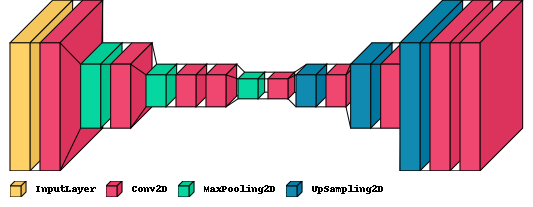

In [ ]:
visualkeras.layered_view(autoencoder2,legend=True)

In [ ]:
training_time_start = time.time()
history2 = autoencoder2.fit(X_train_norm, X_train_norm, steps_per_epoch =(50000//128), validation_steps =(10000//128) ,validation_data = (X_test_norm,X_test_norm), batch_size=128, shuffle=True, epochs = 50, callbacks=[early_stopping])
training_time_end = time.time()
print(f"Training Time: {training_time_end - training_time_start}")

Epoch 1/50
390/390 [==============================] - 12s 18ms/step - loss: 0.0309 - accuracy: 0.4785 - val_loss: 0.0169 - val_accuracy: 0.5998
Epoch 2/50
390/390 [==============================] - 7s 17ms/step - loss: 0.0153 - accuracy: 0.6147 - val_loss: 0.0140 - val_accuracy: 0.6310
Epoch 3/50
390/390 [==============================] - 6s 15ms/step - loss: 0.0135 - accuracy: 0.6279 - val_loss: 0.0127 - val_accuracy: 0.6218
Epoch 4/50
390/390 [==============================] - 7s 17ms/step - loss: 0.0124 - accuracy: 0.6409 - val_loss: 0.0119 - val_accuracy: 0.6354
Epoch 5/50
390/390 [==============================] - 6s 15ms/step - loss: 0.0117 - accuracy: 0.6597 - val_loss: 0.0113 - val_accuracy: 0.6797
Epoch 6/50
390/390 [==============================] - 7s 17ms/step - loss: 0.0112 - accuracy: 0.6787 - val_loss: 0.0109 - val_accuracy: 0.6955
Epoch 7/50
390/390 [==============================] - 6s 16ms/step - loss: 0.0109 - accuracy: 0.6860 - val_loss: 0.0107 - val_accuracy: 0.668

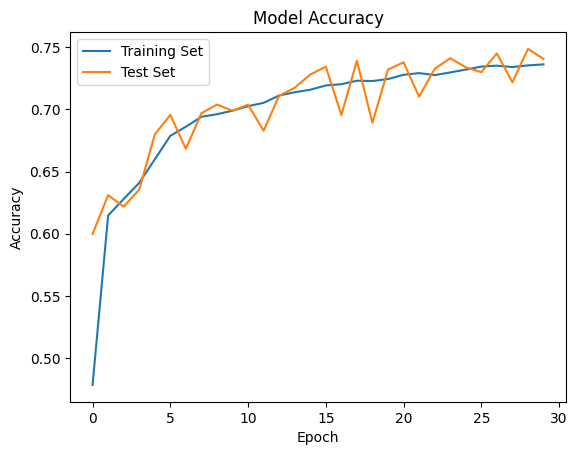

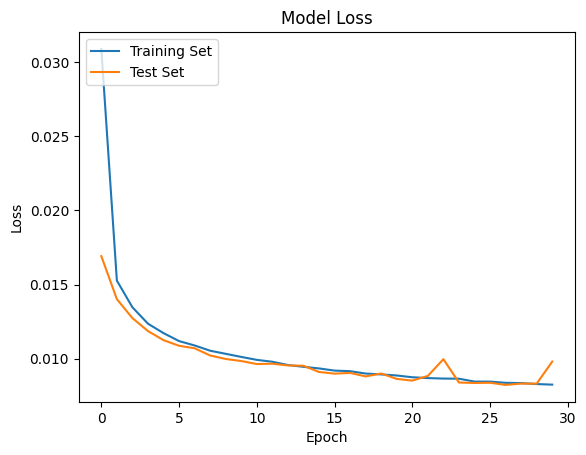

In [ ]:
# summarize history for accuracy
plt.figure(1)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Test Set'], loc='upper left')
plt.show()

plt.figure(2)
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Test Set'], loc='upper left')
plt.show()

In [ ]:
encoder2 = keras.Model(inputs = inputs, outputs = encoded)

In [ ]:
reconstructed_images_test = autoencoder2.predict(X_test_norm)
reconstructed_images_train = autoencoder2.predict(X_train_norm)
encoded_images_test = encoder2.predict(X_test_norm)
print('Encoded Images Dimensions:', encoded_images_test.shape)
reconstructed_images_test = autoencoder2.predict(X_test_norm)
print('Decoded Images Dimensions:', reconstructed_images_test.shape)

313/313 [==============================] - 1s 2ms/step
Encoded Images Dimensions: (10000, 4, 4, 8)
313/313 [==============================] - 1s 2ms/step
Decoded Images Dimensions: (10000, 32, 32, 3)


In [ ]:
# Reconstruction Metrics Calculation
ssim_train = ssim_calculation(X_train_norm, reconstructed_images_train, 'Training Set')
ssim_test = ssim_calculation(X_test_norm, reconstructed_images_test, 'Test Set')

mse_rmse_calculation(X_train_norm, reconstructed_images_train, 'Training Set')
mse_rmse_calculation(X_test_norm, reconstructed_images_test, 'Test Set')

Average Structural Similarity Index (SSIM) in Training Set: 0.7200059294700623
Average Structural Similarity Index (SSIM) in Test Set: 0.7198789119720459
Metrics of Training Set:
Mean Squared Error (MSE): 0.008229609578847885
Root Mean Squared Error (RMSE): 0.09071719646453857
Metrics of Test Set:
Mean Squared Error (MSE): 0.008237142115831375
Root Mean Squared Error (RMSE): 0.09075870364904404


(0.008237142, 0.0907587)

We can see that in Model 2, significant metrics have been produced by compressing the image a lot. The compressed dimensions is (4,4,8) and it is less than the PCA of 95%.

## **Hyper Parameter Tuning Process for the AutoEncoders**

Creating a new process for Hyperaparameter tuning based on the unique architectures that the encoders and decoders have.
This means that the layers that enter that encoder should be added in the decoder in reverse order. Attention should be paid in the fact that the autoencoder should actually perform dimensionality reduction and thus the latent vector be small.

In [ ]:
!pip install keras-tuner --upgrade
from keras_tuner.tuners import RandomSearch,BayesianOptimization,GridSearch
from keras_tuner.engine.hyperparameters import HyperParameters
# Early Stopping for the training process
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
# Function for building autoencoder architectures
# This function is based on the normal hyperparameter tuning but keeps the normal architectures of the autoencoders
def build_autoencoder(hp):
    input_layer = keras.layers.Input(shape=(32, 32, 3))
    x = input_layer

    # Encoder
    encoder_layers = []
    # Storing the Encoder layers in order to use them in the decoder
    for i in range(hp.Int('num_layers_encoder', min_value=0, max_value=3)):
        x = keras.layers.Conv2D(hp.Int(f'filters_encoder_{i}', min_value=32, max_value=256, step=32),
                                hp.Int(f'kernel_size_encoder_{i}', min_value=3, max_value=5),
                                padding='same', activation='relu')(x)
        encoder_layers.append(x)
        x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

    # last layer -> bottle neck
    filters_last = hp.Int('filters_encoder_last', min_value=4, max_value=128, step=32)
    kernel_size_last = hp.Int('kernel_size_encoder_last', min_value=2, max_value=3)
    x = keras.layers.Conv2D(filters_last, kernel_size_last,padding='same', activation='relu')(x)
    # Bottle neck layer
    bottle_neck = x

    # Decoder
    x = keras.layers.Conv2D(filters_last, kernel_size_last,padding='same', activation='relu')(x)

    # Adding the layers of the Encoder in the Decoder in Reverse Order, followed by Upsampling Layers -> Could Also use Conv2DTranspose
    for i, encoder_layer in enumerate(reversed(encoder_layers)):
        x = keras.layers.Conv2D(encoder_layer.shape[-1],
                                encoder_layer.shape[1:3],
                                padding='same', activation='relu')(x)
        x = keras.layers.UpSampling2D(size=(2, 2))(x)

    # Output layer
    output_layer = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    # Build the autoencoder model
    autoencoder = keras.models.Model(inputs=input_layer, outputs=output_layer)

    # Compile the Created Autoencoder
    optimizer = keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log'))
    autoencoder.compile(loss='mean_squared_error', metrics=['accuracy'], optimizer=optimizer)

    return autoencoder

In [ ]:
# Instantiate the Random Search tuner
tuner = RandomSearch(
    build_autoencoder,
    objective='val_loss',
    max_trials=20,
    directory='random_tuner_results',
    project_name='autoencoder_tuning',
    overwrite=True
)

# Perform the hyperparameter search
tuner.search(X_train_norm, X_train_norm, epochs=20, validation_data=(X_test_norm, X_test_norm), callbacks=[early_stopping],use_multiprocessing =True)

# Check the best hyperparameters
best_hp_autoencoder = tuner.get_best_hyperparameters(1)[0].values
print("Best Hyperparameters for Autoencoder:", best_hp_autoencoder)

# Build the autoencoder with the best hyperparameters
best_autoencoder_random_search = tuner.get_best_models(num_models=1)[0]
print(best_autoencoder_random_search.summary())

Trial 4 Complete [00h 53m 27s]
val_loss: 0.0035993836354464293

Best val_loss So Far: 1.3397929251368623e-05
Total elapsed time: 01h 01m 47s

Search: Running Trial #5

Value             |Best Value So Far |Hyperparameter
3                 |0                 |num_layers_encoder
36                |100               |filters_encoder_last
2                 |2                 |kernel_size_encoder_last
6.7252e-05        |0.0068257         |learning_rate
192               |192               |filters_encoder_0
5                 |3                 |kernel_size_encoder_0
256               |None              |filters_encoder_1
3                 |None              |kernel_size_encoder_1
96                |None              |filters_encoder_2
5                 |None              |kernel_size_encoder_2

Epoch 1/20
   6/1563 [..............................] - ETA: 4:50 - loss: 0.0623 - accuracy: 0.2394

1563/1563 [==============================] - 397s 243ms/step - loss: 0.0182 - accuracy: 0.6529 - val_loss: 0.0121 - val_accuracy: 0.7118
Epoch 2/20
1563/1563 [==============================] - 387s 247ms/step - loss: 0.0109 - accuracy: 0.7326 - val_loss: 0.0097 - val_accuracy: 0.7421
Epoch 3/20
1563/1563 [==============================] - 386s 247ms/step - loss: 0.0091 - accuracy: 0.7528 - val_loss: 0.0084 - val_accuracy: 0.7575
Epoch 4/20
1563/1563 [==============================] - 386s 247ms/step - loss: 0.0081 - accuracy: 0.7628 - val_loss: 0.0076 - val_accuracy: 0.7733
Epoch 5/20
1563/1563 [==============================] - 365s 234ms/step - loss: 0.0073 - accuracy: 0.7700 - val_loss: 0.0070 - val_accuracy: 0.7779
Epoch 6/20
1563/1563 [==============================] - 387s 248ms/step - loss: 0.0067 - accuracy: 0.7746 - val_loss: 0.0063 - val_accuracy: 0.7843
Epoch 7/20
1563/1563 [==============================] - 386s 247ms/step - loss: 0.0061 - accuracy: 0.7792 - val_loss: 0.006

In [ ]:
# Checking the Reconstruction Metrics for the best Model
reconstructed_images_train = best_autoencoder_random_search.predict(X_train_norm)
reconstructed_images_test = best_autoencoder_random_search.predict(X_test_norm)

ssim_train = ssim_calculation(X_train_norm, reconstructed_images_train, 'Training Set')
ssim_test = ssim_calculation(X_test_norm, reconstructed_images_test, 'Test Set')

mse_rmse_calculation(X_train_norm, reconstructed_images_train, 'Training Set')
mse_rmse_calculation(X_test_norm, reconstructed_images_test, 'Test Set')

In [ ]:
# Instantiate the Bayesian Optimization tuner
tuner = BayesianOptimization(
    build_autoencoder,
    objective='val_loss',
    max_trials=20,
    directory='random_tuner_results',
    project_name='autoencoder_tuning',
    overwrite=True
)

# Perform the hyperparameter search
tuner.search(X_train_norm,X_train_norm ,epochs = 20,validation_data=(X_test_norm, X_test_norm),callbacks=[early_stopping],use_multiprocessing =True)

# Check the Best Hyperparameters
best_hp = tuner.get_best_hyperparameters(1)[0].values
print("Best Hyperparameters:", best_hp)

# Build the model with the best hyperparameters
best_autoencoder_bayesian_optimization = tuner.get_best_models(num_models=1)[0]
print(best_autoencoder_bayesian_optimization.summary())

In [ ]:
# Checking the Reconstruction Metrics
reconstructed_images_train = best_autoencoder_bayesian_optimization.predict(X_train_norm)
reconstructed_images_test = best_autoencoder_bayesian_optimization.predict(X_test_norm)

ssim_train = ssim_calculation(X_train_norm, reconstructed_images_train, 'Training Set')
ssim_test = ssim_calculation(X_test_norm, reconstructed_images_test, 'Test Set')

mse_rmse_calculation(X_train_norm, reconstructed_images_train, 'Training Set')
mse_rmse_calculation(X_test_norm, reconstructed_images_test, 'Test Set')

In [ ]:
import keras

# Building one of the best models found during Search
def build_best_autoencoder():
    input_layer = keras.layers.Input(shape=(32, 32, 3))
    x = input_layer

    # Encoder
    encoder_layers = []
    # Encoder Layer 1
    x = keras.layers.Conv2D(192, 5, padding='same', activation='relu')(x)
    encoder_layers.append(x)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

    # last layer -> bottle neck
    filters_last = 100
    kernel_size_last = 2
    x = keras.layers.Conv2D(filters_last, kernel_size_last, padding='same', activation='relu')(x)

    # Bottle neck layer
    bottle_neck = x

    # Decoder
    x = keras.layers.Conv2D(filters_last, kernel_size_last, padding='same', activation='relu')(x)

    # Decoder Layer 1
    x = keras.layers.Conv2D(192, (5, 5), padding='same', activation='relu')(x)
    x = keras.layers.UpSampling2D(size=(2, 2))(x)

    # Output layer
    output_layer = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    # Build the autoencoder model
    autoencoder = keras.models.Model(inputs=input_layer, outputs=output_layer)

    # Compile the Created Autoencoder
    optimizer = keras.optimizers.Adam(learning_rate=6.7252e-05)
    autoencoder.compile(loss='mean_squared_error', metrics=['accuracy'], optimizer=optimizer)

    return autoencoder

# Create the best model
best_autoencoder_model = build_best_autoencoder()
best_history = best_autoencoder_model.fit(X_train_norm, X_train_norm, steps_per_epoch =(50000//128), validation_steps =(10000//128) ,validation_data = (X_test_norm,X_test_norm), batch_size=128, shuffle=True, epochs = 50, callbacks=[early_stopping])

Epoch 1/50
390/390 [==============================] - 23s 46ms/step - loss: 0.0159 - accuracy: 0.6892 - val_loss: 0.0053 - val_accuracy: 0.7720
Epoch 2/50
390/390 [==============================] - 18s 42ms/step - loss: 0.0043 - accuracy: 0.7851 - val_loss: 0.0035 - val_accuracy: 0.7934
Epoch 3/50
390/390 [==============================] - 17s 42ms/step - loss: 0.0032 - accuracy: 0.8035 - val_loss: 0.0028 - val_accuracy: 0.8126
Epoch 4/50
390/390 [==============================] - 16s 42ms/step - loss: 0.0026 - accuracy: 0.8132 - val_loss: 0.0024 - val_accuracy: 0.8217
Epoch 5/50
390/390 [==============================] - 16s 42ms/step - loss: 0.0022 - accuracy: 0.8212 - val_loss: 0.0021 - val_accuracy: 0.8178
Epoch 6/50
390/390 [==============================] - 17s 43ms/step - loss: 0.0020 - accuracy: 0.8298 - val_loss: 0.0019 - val_accuracy: 0.8316
Epoch 7/50
390/390 [==============================] - 17s 43ms/step - loss: 0.0018 - accuracy: 0.8358 - val_loss: 0.0017 - val_accuracy:

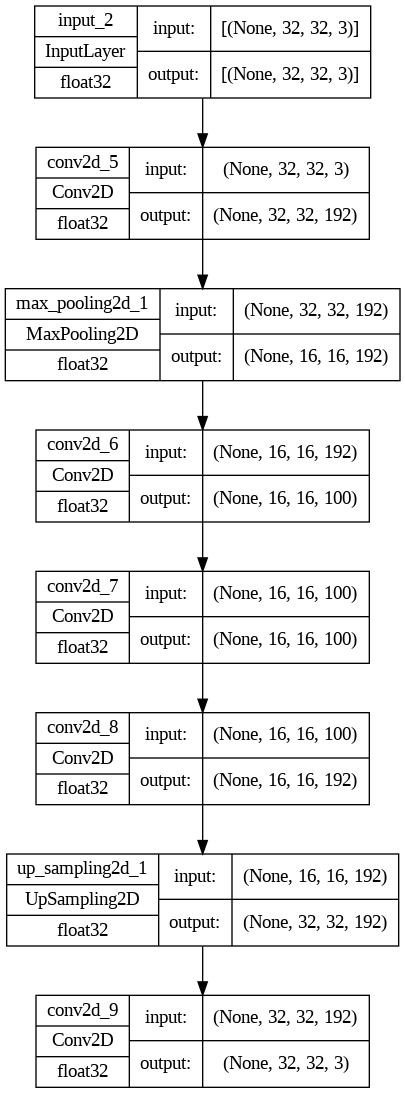

In [ ]:
keras.utils.plot_model(best_autoencoder_model, "best_autoencoder.png", show_shapes = True, show_dtype = True)

In [ ]:
# Check Reconstruction Metrics
reconstructed_images_train = best_autoencoder_model.predict(X_train_norm)
reconstructed_images_test = best_autoencoder_model.predict(X_test_norm)

ssim_train = ssim_calculation(X_train_norm, reconstructed_images_train, 'Training Set')
ssim_test = ssim_calculation(X_test_norm, reconstructed_images_test, 'Test Set')

mse_rmse_calculation(X_train_norm, reconstructed_images_train, 'Training Set')
mse_rmse_calculation(X_test_norm, reconstructed_images_test, 'Test Set')

313/313 [==============================] - 1s 4ms/step
Average Structural Similarity Index (SSIM) in Training Set: 0.9833967089653015
Average Structural Similarity Index (SSIM) in Test Set: 0.9834299683570862
Metrics of Training Set:
Mean Squared Error (MSE): 0.0005050792824476957
Root Mean Squared Error (RMSE): 0.02247396856546402
Metrics of Test Set:
Mean Squared Error (MSE): 0.0005044914432801306
Root Mean Squared Error (RMSE): 0.02246088720858097


(0.00050449144, 0.022460887)

As expected, the reconstruction can be very precise. However, the best model does not perform dimensionality reduction, it just represents the data with a different vector. I am going to try and search for **models that perform dimensionality reduction** as well, by altering the parameters of the models that are builded. In the following cells, I am going to perform hyperparameter tuning for models that perform some dimensionality reduction, by checking the number of features at the end of the encoder before the start of the training of each model.

**CallBack Keras Function to stop the training if Dimensionality Reduction is not performed**

In [ ]:
from keras import backend as K
import tensorflow as tf

# Define a custom callback to enforce that the bottleneck will have a smaller
# Feature vector than the original image and thus Dimensionality Reduction
# is performed
class FeatureVectorCallback(tf.keras.callbacks.Callback):
    def __init__(self, max_feature_vector):
        super(FeatureVectorCallback, self).__init__()
        self.max_feature_vector = max_feature_vector

    # Function that will be called before the start of the model training
    def on_train_begin(self,logs=None):
        smallest_feature_vector = float('inf')
        smallest_feature_vector_layer = None

        for layer in self.model.layers:
            # Check the last layer of the encoder by using the custom name of the layer
            if layer.name == 'last_layer_encoder':
                bottleneck_dimensions = K.int_shape(layer.output)[1:]
                width, length, channels = bottleneck_dimensions
                feature_vector = width * length * channels

                print(f"Model's Bottleneck Feature Vector: {feature_vector}")

                if feature_vector < smallest_feature_vector:
                    smallest_feature_vector = feature_vector
                    smallest_feature_vector_layer = layer

        if smallest_feature_vector >= self.max_feature_vector:
            print(f"Stopping training due to smallest feature_vector {smallest_feature_vector} >= {self.max_feature_vector}")
            self.model.stop_training = True

**Hyperparameter tuning for optimal AutoEncoder that will perform Dimensionality Reduction as well**

In [ ]:
# This function will be used with the above callback to ensure the dimensionality reduction in the encoded images
def build_autoencoder_smaller_bottleneck_dimensions(hp):

    filters_last = None
    kernel_size_last = None

    input_layer = keras.layers.Input(shape=(32, 32, 3))
    x = input_layer
    # Encoder
    encoder_layers = []
    for i in range(hp.Int('num_layers_encoder', min_value=0, max_value=3)):
        x = keras.layers.Conv2D(hp.Int(f'filters_encoder_{i}', min_value=4, max_value=128, step=16), kernel_size=(3,3),
                                padding='same', activation='relu')(x)
        encoder_layers.append(x)
        x = keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x)

    # last layer -> bottleneck
    filters_last = hp.Int('filters_encoder_last', min_value=4, max_value=32, step=4)
    kernel_size_last = hp.Int('kernel_size_encoder_last', min_value=2, max_value=5)

    x = keras.layers.Conv2D(filters_last,kernel_size = kernel_size_last, padding='same', activation='relu',name='last_layer_encoder')(x)

    bottleneck = x
    # check that there is dimensionality reduction by checking the feature vector
    # bottleneck_dimensions = K.int_shape(bottleneck)[1:]
    # width, length, channels = bottleneck_dimensions

    # # Multiply width, length, and channels
    # feature_vector = width * length * channels
    # print(feature_vector)

    # Decoder
    x = keras.layers.Conv2D(filters_last,kernel_size = kernel_size_last,padding='same', activation='relu')(x)

    for i, encoder_layer in enumerate(reversed(encoder_layers)):
        x = keras.layers.Conv2D(encoder_layer.shape[-1],
                                encoder_layer.shape[1:3],
                                padding='same', activation='relu')(x)
        x = keras.layers.UpSampling2D(size=(2, 2))(x)

    # Output layer
    output_layer = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    # Build the autoencoder model
    autoencoder = keras.models.Model(inputs=input_layer, outputs=output_layer)

    # Compile the Created Autoencoder
    optimizer = keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log'))
    autoencoder.compile(loss='mean_squared_error', metrics=['accuracy'], optimizer=optimizer)

    return autoencoder

In [ ]:
# Instantiate the Random Search tuner
tuner = RandomSearch(
    build_autoencoder_smaller_bottleneck_dimensions,
    objective='val_loss',
    max_trials = 15,
    directory='random_tuner_results_dimensionality_reduction',
    project_name='autoencoder_tuning',
    overwrite=True
)
# Initiate a Callback Object
feature_vector_callback = FeatureVectorCallback(max_feature_vector=32*32*3)

# Perform the hyperparameter search
tuner.search(X_train_norm, X_train_norm, epochs=20, validation_data=(X_test_norm, X_test_norm), callbacks=[early_stopping,feature_vector_callback],use_multiprocessing =True)


Trial 15 Complete [00h 01m 14s]
val_loss: 0.06266115605831146

Best val_loss So Far: 0.0005133062950335443
Total elapsed time: 00h 46m 58s


In [ ]:
# Check the best hyperparameters
best_hp_autoencoder_dr = tuner.get_best_hyperparameters(1)[0].values
print("Best Hyperparameters for Autoencoder:", best_hp_autoencoder_dr)

# Build the autoencoder with the best hyperparameters
best_autoencoder_random_search_dr = tuner.get_best_models(num_models=1)[0]
print(best_autoencoder_random_search_dr.summary())

Best Hyperparameters for Autoencoder: {'num_layers_encoder': 1, 'filters_encoder_last': 8, 'kernel_size_encoder_last': 5, 'learning_rate': 0.000900841586581104, 'filters_encoder_0': 84}
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 84)        2352      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 84)        0         
 D)                                                              
                                                                 
 last_layer_encoder (Conv2D  (None, 16, 16, 8)         16808     
 )                                                               
                                                                 
 conv2d

In [ ]:
# Best Model Reconstruction Metrics Calculated
reconstructed_images_train = best_autoencoder_random_search_dr.predict(X_train_norm)
reconstructed_images_test = best_autoencoder_random_search_dr.predict(X_test_norm)

ssim_train = ssim_calculation(X_train_norm, reconstructed_images_train, 'Training Set')
ssim_test = ssim_calculation(X_test_norm, reconstructed_images_test, 'Test Set')

mse_rmse_calculation(X_train_norm, reconstructed_images_train, 'Training Set')
mse_rmse_calculation(X_test_norm, reconstructed_images_test, 'Test Set')

313/313 [==============================] - 1s 3ms/step
Average Structural Similarity Index (SSIM) in Training Set: 0.9843966364860535
Average Structural Similarity Index (SSIM) in Test Set: 0.9844348430633545
Metrics of Training Set:
Mean Squared Error (MSE): 0.0005120598361827433
Root Mean Squared Error (RMSE): 0.02262873947620392
Metrics of Test Set:
Mean Squared Error (MSE): 0.0005133061204105616
Root Mean Squared Error (RMSE): 0.022656260058283806


(0.0005133061, 0.02265626)

In [ ]:
tuner.results_summary() # tuner results summary

Results summary
Results in random_tuner_results_dimensionality_reduction/autoencoder_tuning
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 02 summary
Hyperparameters:
num_layers_encoder: 1
filters_encoder_last: 8
kernel_size_encoder_last: 5
learning_rate: 0.000900841586581104
filters_encoder_0: 84
Score: 0.0005133062950335443

Trial 01 summary
Hyperparameters:
num_layers_encoder: 1
filters_encoder_last: 8
kernel_size_encoder_last: 3
learning_rate: 0.0011957498177723963
filters_encoder_0: 4
Score: 0.003369805635884404

Trial 13 summary
Hyperparameters:
num_layers_encoder: 2
filters_encoder_last: 8
kernel_size_encoder_last: 5
learning_rate: 8.017064422524535e-05
filters_encoder_0: 52
filters_encoder_1: 100
filters_encoder_2: 84
Score: 0.003679996822029352

Trial 06 summary
Hyperparameters:
num_layers_encoder: 2
filters_encoder_last: 24
kernel_size_encoder_last: 5
learning_rate: 0.00028745791047186465
filters_encoder_0: 4
filters_encoder_1: 52
filters_encoder_2:

In [ ]:
# Instantiate the Bayesian Optimization tuner
tuner = BayesianOptimization(
    build_autoencoder_smaller_bottleneck_dimensions,
    objective='val_loss',
    max_trials=15,
    directory='bayesian_tuner_results_dimensionality_reduction',
    project_name='autoencoder_tuning',
    overwrite=True
)

# Instantiate the callback
feature_vector_callback = FeatureVectorCallback(max_feature_vector=32*32*3)

# Perform the hyperparameter search
tuner.search(X_train_norm, X_train_norm, epochs=20, validation_data=(X_test_norm, X_test_norm), callbacks=[early_stopping,feature_vector_callback],use_multiprocessing =True)

# Check the Best Hyperparameters
best_hp = tuner.get_best_hyperparameters(1)[0].values
print("Best Hyperparameters:", best_hp)

# Build the model with the best hyperparameters
best_autoencoder_bayesian_optimization_dr = tuner.get_best_models(num_models=1)[0]

Trial 15 Complete [00h 00m 10s]
val_loss: 0.0631261020898819

Best val_loss So Far: 0.000980290351435542
Total elapsed time: 00h 43m 37s
Best Hyperparameters: {'num_layers_encoder': 1, 'filters_encoder_last': 8, 'kernel_size_encoder_last': 4, 'learning_rate': 0.0004991244511033043, 'filters_encoder_0': 36, 'filters_encoder_1': 52}


In [ ]:
# Reconstruction Metrics Calculation
reconstructed_images_train = best_autoencoder_bayesian_optimization_dr.predict(X_train_norm)
reconstructed_images_test = best_autoencoder_bayesian_optimization_dr.predict(X_test_norm)

ssim_train = ssim_calculation(X_train_norm, reconstructed_images_train, 'Training Set')
ssim_test = ssim_calculation(X_test_norm, reconstructed_images_test, 'Test Set')

mse_rmse_calculation(X_train_norm, reconstructed_images_train, 'Training Set')
mse_rmse_calculation(X_test_norm, reconstructed_images_test, 'Test Set')

313/313 [==============================] - 1s 3ms/step
Average Structural Similarity Index (SSIM) in Training Set: 0.9710395932197571
Average Structural Similarity Index (SSIM) in Test Set: 0.9710984230041504
Metrics of Training Set:
Mean Squared Error (MSE): 0.0009812797652557492
Root Mean Squared Error (RMSE): 0.031325384974479675
Metrics of Test Set:
Mean Squared Error (MSE): 0.0009802909335121512
Root Mean Squared Error (RMSE): 0.031309597194194794


(0.0009802909, 0.031309597)

In [ ]:
print(best_autoencoder_bayesian_optimization_dr.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 36)        1008      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 36)        0         
 D)                                                              
                                                                 
 last_layer_encoder (Conv2D  (None, 16, 16, 8)         4616      
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 8)         1032      
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 36)        294948

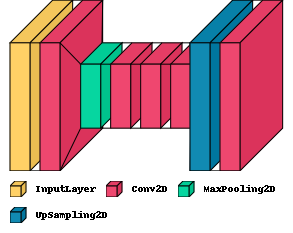

In [ ]:
visualkeras.layered_view(best_autoencoder_bayesian_optimization_dr,legend=True)

**Extra models for PCA Comparison**

In the following cells, I recreated some autoencoding neural networks that showed good performance in comparison with other models with the same number of features in the encoded images. These models will be compared with the results of the PCA in order to compare the autoencoders with PCA reconstruction.

Model with 512 features in the bottleneck

In [ ]:
# Create a model with 512 features in the bottleneck
inputs = keras.layers.Input(shape = (32,32,3),name = "input")

x = keras.layers.Conv2D(128, (3,3), activation = 'relu', padding = 'same', name = 'Conv2D_1')(inputs)
x = keras.layers.MaxPooling2D(pool_size = (2,2), padding = 'same', name = 'MaxPool_1')(x)

x = keras.layers.Conv2D(128,(3,3), activation = 'relu', padding = 'same', name = 'Conv2D_2')(x)
x = keras.layers.MaxPooling2D(pool_size = (2,2), padding = 'same', name = 'MaxPool_2')(x)

x = keras.layers.Conv2D(64,(3,3), activation = 'relu', padding = 'same', name = 'Conv2D_3')(x)
x = keras.layers.MaxPooling2D(pool_size = (2,2), padding = 'same', name = 'MaxPool_3')(x)

bottle_neck = keras.layers.Conv2D(32, (3, 3), activation = 'relu', padding = 'same', name = 'Bottle_neck')(x) # 4*4*32 = 512

x = keras.layers.Conv2D(64, (3, 3), activation = 'relu', padding = 'same', name = 'Conv2D_4')(bottle_neck)
x = keras.layers.UpSampling2D(size = (2, 2), name = 'UpSample_1')(x)

x = keras.layers.Conv2D(128, (3, 3), activation = 'relu', padding = 'same', name = 'Conv2D_5')(x)
x = keras.layers.UpSampling2D(size = (2, 2), name = 'UpSample_2')(x)

x = keras.layers.Conv2D(128, (3, 3), activation = 'relu', padding = 'same', name = 'Conv2D_6')(x)
x = keras.layers.UpSampling2D(size = (2, 2), name = 'UpSample_3')(x)

outputs = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding = 'same', name = 'output')(x)

autoencoder_512 = keras.Model(inputs, outputs, name = "Model_1")

autoencoder_512.compile(optimizer = 'adam', metrics = ['accuracy'], loss = 'mean_squared_error')
autoencoder_512.summary()

Model: "Model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 32, 32, 3)]       0         
                                                                 
 Conv2D_1 (Conv2D)           (None, 32, 32, 128)       3584      
                                                                 
 MaxPool_1 (MaxPooling2D)    (None, 16, 16, 128)       0         
                                                                 
 Conv2D_2 (Conv2D)           (None, 16, 16, 128)       147584    
                                                                 
 MaxPool_2 (MaxPooling2D)    (None, 8, 8, 128)         0         
                                                                 
 Conv2D_3 (Conv2D)           (None, 8, 8, 64)          73792     
                                                                 
 MaxPool_3 (MaxPooling2D)    (None, 4, 4, 64)          0   

In [ ]:
history_512 = autoencoder_512.fit(X_train_norm, X_train_norm, steps_per_epoch =(50000//128), validation_steps =(10000//128) ,validation_data = (X_test_norm,X_test_norm), batch_size=128, shuffle=True, epochs = 50, callbacks=[early_stopping])

Epoch 1/50
390/390 [==============================] - 25s 29ms/step - loss: 0.0185 - accuracy: 0.6240 - val_loss: 0.0119 - val_accuracy: 0.7182
Epoch 2/50
390/390 [==============================] - 11s 26ms/step - loss: 0.0105 - accuracy: 0.7313 - val_loss: 0.0096 - val_accuracy: 0.7512
Epoch 3/50
390/390 [==============================] - 11s 28ms/step - loss: 0.0091 - accuracy: 0.7443 - val_loss: 0.0084 - val_accuracy: 0.7374
Epoch 4/50
390/390 [==============================] - 11s 28ms/step - loss: 0.0082 - accuracy: 0.7501 - val_loss: 0.0078 - val_accuracy: 0.7588
Epoch 5/50
390/390 [==============================] - 11s 27ms/step - loss: 0.0074 - accuracy: 0.7552 - val_loss: 0.0069 - val_accuracy: 0.7729
Epoch 6/50
390/390 [==============================] - 10s 26ms/step - loss: 0.0068 - accuracy: 0.7591 - val_loss: 0.0064 - val_accuracy: 0.7652
Epoch 7/50
390/390 [==============================] - 10s 27ms/step - loss: 0.0065 - accuracy: 0.7594 - val_loss: 0.0065 - val_accuracy:

In [ ]:
# Reconstuction Metrics Calculation for model with 512 features at the bottleneck
reconstructed_images_train = autoencoder_512.predict(X_train_norm)
reconstructed_images_test = autoencoder_512.predict(X_test_norm)

ssim_train = ssim_calculation(X_train_norm, reconstructed_images_train, 'Training Set')
ssim_test = ssim_calculation(X_test_norm, reconstructed_images_test, 'Test Set')

mse_rmse_calculation(X_train_norm, reconstructed_images_train, 'Training Set')
mse_rmse_calculation(X_test_norm, reconstructed_images_test, 'Test Set')

Model with 256 features in the bottleneck

In [ ]:
# Create a model with 256 features in the bottleneck
inputs = keras.layers.Input(shape = (32,32,3),name = "input")

x = keras.layers.Conv2D(128, (3,3), activation = 'relu', padding = 'same', name = 'Conv2D_1')(inputs)
x = keras.layers.MaxPooling2D(pool_size = (2,2), padding = 'same', name = 'MaxPool_1')(x)

x = keras.layers.Conv2D(64,(3,3), activation = 'relu', padding = 'same', name = 'Conv2D_2')(x)
x = keras.layers.MaxPooling2D(pool_size = (2,2), padding = 'same', name = 'MaxPool_2')(x)

x = keras.layers.Conv2D(32,(3,3), activation = 'relu', padding = 'same', name = 'Conv2D_3')(x)
x = keras.layers.MaxPooling2D(pool_size = (2,2), padding = 'same', name = 'MaxPool_3')(x)


bottle_neck = keras.layers.Conv2D(16, (3, 3), activation = 'relu', padding = 'same', name = 'Bottle_neck')(x) # 4*4*16=256

x = keras.layers.Conv2D(32, (3, 3), activation = 'relu', padding = 'same', name = 'Conv2D_4')(bottle_neck)
x = keras.layers.UpSampling2D(size = (2, 2), name = 'UpSample_1')(x)

x = keras.layers.Conv2D(64, (3, 3), activation = 'relu', padding = 'same', name = 'Conv2D_5')(x)
x = keras.layers.UpSampling2D(size = (2, 2), name = 'UpSample_2')(x)

x = keras.layers.Conv2D(128, (3, 3), activation = 'relu', padding = 'same', name = 'Conv2D_6')(x)
x = keras.layers.UpSampling2D(size = (2, 2), name = 'UpSample_3')(x)

outputs = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding = 'same', name = 'output')(x)

autoencoder_256 = keras.Model(inputs, outputs, name = "Model_1")

autoencoder_256.compile(optimizer = 'adam', metrics = ['accuracy'], loss = 'mean_squared_error')
autoencoder_256.summary()

Model: "Model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 32, 32, 3)]       0         
                                                                 
 Conv2D_1 (Conv2D)           (None, 32, 32, 128)       3584      
                                                                 
 MaxPool_1 (MaxPooling2D)    (None, 16, 16, 128)       0         
                                                                 
 Conv2D_2 (Conv2D)           (None, 16, 16, 64)        73792     
                                                                 
 MaxPool_2 (MaxPooling2D)    (None, 8, 8, 64)          0         
                                                                 
 Conv2D_3 (Conv2D)           (None, 8, 8, 32)          18464     
                                                                 
 MaxPool_3 (MaxPooling2D)    (None, 4, 4, 32)          0   

In [ ]:
history_256 = autoencoder_256.fit(X_train_norm, X_train_norm, steps_per_epoch =(50000//128), validation_steps =(10000//128) ,validation_data = (X_test_norm,X_test_norm), batch_size=128, shuffle=True, epochs = 50, callbacks=[early_stopping])

Epoch 1/50
390/390 [==============================] - 16s 26ms/step - loss: 0.0203 - accuracy: 0.5895 - val_loss: 0.0138 - val_accuracy: 0.6527
Epoch 2/50
390/390 [==============================] - 11s 25ms/step - loss: 0.0124 - accuracy: 0.6827 - val_loss: 0.0112 - val_accuracy: 0.7019
Epoch 3/50
390/390 [==============================] - 9s 24ms/step - loss: 0.0110 - accuracy: 0.7161 - val_loss: 0.0102 - val_accuracy: 0.7314
Epoch 4/50
390/390 [==============================] - 9s 23ms/step - loss: 0.0101 - accuracy: 0.7288 - val_loss: 0.0097 - val_accuracy: 0.7251
Epoch 5/50
390/390 [==============================] - 9s 23ms/step - loss: 0.0096 - accuracy: 0.7346 - val_loss: 0.0095 - val_accuracy: 0.7360
Epoch 6/50
390/390 [==============================] - 9s 22ms/step - loss: 0.0092 - accuracy: 0.7381 - val_loss: 0.0088 - val_accuracy: 0.7396
Epoch 7/50
390/390 [==============================] - 9s 23ms/step - loss: 0.0089 - accuracy: 0.7409 - val_loss: 0.0088 - val_accuracy: 0.75

In [ ]:
# Reconstruction Metrics for Model with 256 Features
reconstructed_images_train = autoencoder_256.predict(X_train_norm)
reconstructed_images_test = autoencoder_256.predict(X_test_norm)

ssim_train = ssim_calculation(X_train_norm, reconstructed_images_train, 'Training Set')
ssim_test = ssim_calculation(X_test_norm, reconstructed_images_test, 'Test Set')

mse_rmse_calculation(X_train_norm, reconstructed_images_train, 'Training Set')
mse_rmse_calculation(X_test_norm, reconstructed_images_test, 'Test Set')

313/313 [==============================] - 1s 3ms/step
Average Structural Similarity Index (SSIM) in Training Set: 0.8220399022102356
Average Structural Similarity Index (SSIM) in Test Set: 0.8206707835197449
Metrics of Training Set:
Mean Squared Error (MSE): 0.005119588226079941
Root Mean Squared Error (RMSE): 0.07155130058526993
Metrics of Test Set:
Mean Squared Error (MSE): 0.005182275082916021
Root Mean Squared Error (RMSE): 0.07198802381753922


(0.005182275, 0.071988024)

Model with 128 Features at Bottleneck

In [ ]:
# Model with 128 Features at the Bottleneck
inputs = keras.layers.Input(shape = (32,32,3),name = "input")

x = keras.layers.Conv2D(128, (3,3), activation = 'relu', padding = 'same', name = 'Conv2D_1')(inputs)
x = keras.layers.MaxPooling2D(pool_size = (2,2), padding = 'same', name = 'MaxPool_1')(x)

x = keras.layers.Conv2D(64,(3,3), activation = 'relu', padding = 'same', name = 'Conv2D_2')(x)
x = keras.layers.MaxPooling2D(pool_size = (2,2), padding = 'same', name = 'MaxPool_2')(x)

x = keras.layers.Conv2D(32,(3,3), activation = 'relu', padding = 'same', name = 'Conv2D_3')(x)
x = keras.layers.MaxPooling2D(pool_size = (2,2), padding = 'same', name = 'MaxPool_3')(x)


bottle_neck = keras.layers.Conv2D(8, (3, 3), activation = 'relu', padding = 'same', name = 'Bottle_neck')(x) # 4*4*8 = 128 features

encoder_vis = keras.layers.Conv2D(3, (3, 3), activation = 'relu', padding = 'same', name = 'Encoder_vis')(bottle_neck)

x = keras.layers.Conv2D(32, (3, 3), activation = 'relu', padding = 'same', name = 'Conv2D_4')(bottle_neck)
x = keras.layers.UpSampling2D(size = (2, 2), name = 'UpSample_1')(x)

x = keras.layers.Conv2D(64, (3, 3), activation = 'relu', padding = 'same', name = 'Conv2D_5')(x)
x = keras.layers.UpSampling2D(size = (2, 2), name = 'UpSample_2')(x)

x = keras.layers.Conv2D(128, (3, 3), activation = 'relu', padding = 'same', name = 'Conv2D_6')(x)
x = keras.layers.UpSampling2D(size = (2, 2), name = 'UpSample_3')(x)

outputs = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding = 'same', name = 'output')(x)

autoencoder_128 = keras.Model(inputs, outputs, name = "Model_1")

autoencoder_128.compile(optimizer = 'adam', metrics = ['accuracy'], loss = 'mean_squared_error')
autoencoder_128.summary()

Model: "Model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 32, 32, 3)]       0         
                                                                 
 Conv2D_1 (Conv2D)           (None, 32, 32, 128)       3584      
                                                                 
 MaxPool_1 (MaxPooling2D)    (None, 16, 16, 128)       0         
                                                                 
 Conv2D_2 (Conv2D)           (None, 16, 16, 64)        73792     
                                                                 
 MaxPool_2 (MaxPooling2D)    (None, 8, 8, 64)          0         
                                                                 
 Conv2D_3 (Conv2D)           (None, 8, 8, 32)          18464     
                                                                 
 MaxPool_3 (MaxPooling2D)    (None, 4, 4, 32)          0   

In [ ]:
history_128 = autoencoder_128.fit(X_train_norm, X_train_norm, steps_per_epoch =(50000//128), validation_steps =(10000//128) ,validation_data = (X_test_norm,X_test_norm), batch_size=128, shuffle=True, epochs = 50, callbacks=[early_stopping])

Epoch 1/50
390/390 [==============================] - 13s 26ms/step - loss: 0.0202 - accuracy: 0.5912 - val_loss: 0.0145 - val_accuracy: 0.6330
Epoch 2/50
390/390 [==============================] - 9s 23ms/step - loss: 0.0131 - accuracy: 0.6775 - val_loss: 0.0121 - val_accuracy: 0.7143
Epoch 3/50
390/390 [==============================] - 9s 23ms/step - loss: 0.0116 - accuracy: 0.7093 - val_loss: 0.0108 - val_accuracy: 0.7163
Epoch 4/50
390/390 [==============================] - 12s 30ms/step - loss: 0.0107 - accuracy: 0.7233 - val_loss: 0.0101 - val_accuracy: 0.7373
Epoch 5/50
390/390 [==============================] - 12s 30ms/step - loss: 0.0101 - accuracy: 0.7306 - val_loss: 0.0102 - val_accuracy: 0.7412
Epoch 6/50
390/390 [==============================] - 9s 23ms/step - loss: 0.0097 - accuracy: 0.7355 - val_loss: 0.0094 - val_accuracy: 0.7397
Epoch 7/50
390/390 [==============================] - 9s 23ms/step - loss: 0.0095 - accuracy: 0.7363 - val_loss: 0.0091 - val_accuracy: 0.7

In [ ]:
# Reconstruction Metrics Calculation for the model with 128 features
reconstructed_images_train = autoencoder_128.predict(X_train_norm)
reconstructed_images_test = autoencoder_128.predict(X_test_norm)

ssim_train = ssim_calculation(X_train_norm, reconstructed_images_train, 'Training Set')
ssim_test = ssim_calculation(X_test_norm, reconstructed_images_test, 'Test Set')

mse_rmse_calculation(X_train_norm, reconstructed_images_train, 'Training Set')
mse_rmse_calculation(X_test_norm, reconstructed_images_test, 'Test Set')

313/313 [==============================] - 1s 4ms/step
Average Structural Similarity Index (SSIM) in Training Set: 0.7784757018089294
Average Structural Similarity Index (SSIM) in Test Set: 0.7769887447357178
Metrics of Training Set:
Mean Squared Error (MSE): 0.006415857933461666
Root Mean Squared Error (RMSE): 0.08009905368089676
Metrics of Test Set:
Mean Squared Error (MSE): 0.006481639109551907
Root Mean Squared Error (RMSE): 0.08050862699747086


(0.006481639, 0.08050863)

## **Checking Specific Hyper Parameters**

The kernel_size and filters parameters in Conv2D layers play crucial roles in determining the architecture and behavior of convolutional neural networks (CNNs), including autoencoders. Here's how these parameters affect the network:

**Kernel Size:**

**Smaller Kernel Size**(e.g., (3, 3)):
Encodes local patterns and features.
Leads to more parameter sharing, which can enhance the model's ability to generalize.
Results in a more fine-grained analysis of the input.

**Larger Kernel Size** (e.g., (5, 5) or (7, 7)):
Captures more global patterns and features.
Increases the receptive field, allowing the network to consider larger spatial contexts.
Can capture higher-level features.

**Number of Filters:**

**Fewer Filters:**
Reduces the capacity of the network.
The model may struggle to capture complex patterns and details.
Can lead to underfitting if the model lacks the capacity to represent the data adequately.

**More Filters**:
Increases the capacity of the network.
Enables the model to learn more complex features.
May lead to overfitting if not appropriately regularized.

Combined Effect:

Choosing an appropriate combination of kernel size and number of filters is crucial.
Increasing the number of filters in deeper layers allows the model to learn hierarchical and abstract representations.
Smaller kernel sizes are often used in early layers to capture local details, while larger kernel sizes may be used in deeper layers for more global features.
Computational Considerations:

Smaller kernel sizes generally result in fewer parameters and computations per layer.
Larger kernel sizes or more filters increase the computational load but may enhance representational capacity.
In the context of an autoencoder, these choices impact how well the model can encode and reconstruct information. It's common to start with smaller kernel sizes in the initial layers to capture fine details and progressively increase the size or number of filters in deeper layers to capture more abstract features.

In [ ]:
import time
import matplotlib.pyplot as plt
# Custom Function that creates AutoEncoder and enables the examination of specific hyperparameters while keep the rest of the architecture the same
def build_autoencoder(num_layers_encoder=3, filters_encoder=128, kernel_size_encoder=(3,3), filters_encoder_last=32, kernel_size_encoder_last=(3,3), learning_rate=1e-4):
    input_layer = keras.layers.Input(shape=(32, 32, 3))
    x = input_layer
    encoder_layers = []
    for i in range(num_layers_encoder):
        x = keras.layers.Conv2D(filters_encoder, kernel_size_encoder, padding='same', activation='relu')(x)
        encoder_layers.append(x)
        x = keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x)

    filters_last = filters_encoder_last
    kernel_size_last = kernel_size_encoder_last

    x = keras.layers.Conv2D(filters_last, kernel_size_last, padding='same', activation='relu',name = 'last_layer_encoder')(x)

    bottleneck = x

    x = keras.layers.Conv2D(filters_last, kernel_size_last, padding='same', activation='relu')(x)

    for i, encoder_layer in enumerate(reversed(encoder_layers)):
        x = keras.layers.Conv2D(encoder_layer.shape[-1], encoder_layer.shape[1:3], padding='same', activation='relu')(x)
        x = keras.layers.UpSampling2D(size=(2, 2))(x)

    output_layer = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = keras.models.Model(inputs=input_layer, outputs=output_layer)
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    autoencoder.compile(loss='mean_squared_error', metrics=['accuracy'], optimizer=optimizer)
    return autoencoder
# Function to train the created architecture of AutoEncoder while making sure that dimensionality reduction is performed
def train_autoencoder(autoencoder, X_train_norm, X_test_norm, epochs=10):
    start_time = time.time()
    feature_vector_callback = FeatureVectorCallback(max_feature_vector=32*32*3)
    history = autoencoder.fit(X_train_norm, X_train_norm, validation_data=(X_test_norm, X_test_norm), batch_size=128, shuffle=True, epochs=epochs, callbacks=[early_stopping, feature_vector_callback], verbose=0)
    end_time = time.time()
    training_time = end_time - start_time
    return training_time, history
# Evaluation of the Autoencoder in the test set
def evaluate_autoencoder(autoencoder, X_test_norm):
    reconstruction_error = autoencoder.evaluate(X_test_norm, X_test_norm, verbose=0)[0]
    return reconstruction_error
# Plotting of the results
def plot_results(parameter_values, training_times, reconstruction_errors, parameter_name):
    plt.figure(figsize=(12, 6))

    # Plot Training Time
    plt.subplot(1, 2, 1)
    plt.plot(parameter_values, training_times, marker='o')
    plt.title(f'Training Time vs {parameter_name}')
    plt.xlabel(parameter_name)
    plt.ylabel('Training Time (seconds)')

    # Plot Reconstruction Error
    plt.subplot(1, 2, 2)
    plt.plot(parameter_values, reconstruction_errors, marker='o')
    plt.title(f'Reconstruction Error vs {parameter_name}')
    plt.xlabel(parameter_name)
    plt.ylabel('Reconstruction Error')

    plt.tight_layout()
    plt.show()

**Influence of Number of Layers in AutoEncoders**

Model's Bottleneck Feature Vector: 2048
Model's Bottleneck Feature Vector: 512
Model's Bottleneck Feature Vector: 128


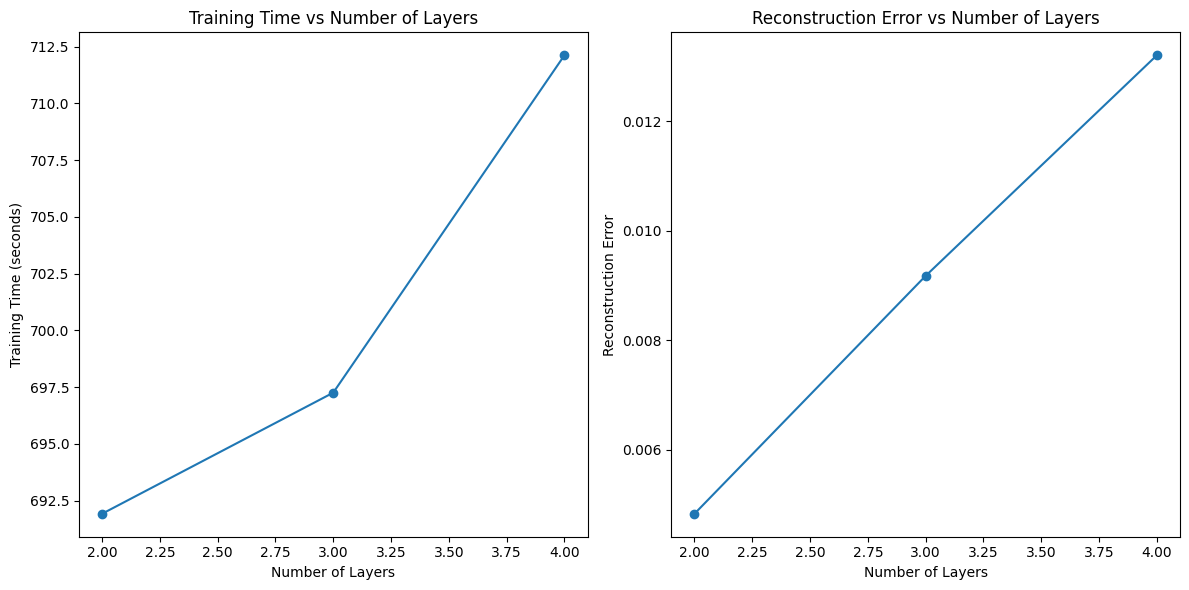

In [ ]:
num_layers_values = [2, 3, 4]

training_times = []
reconstruction_errors = []

for num_layers in num_layers_values:
    autoencoder = build_autoencoder(num_layers)
    training_time, _ = train_autoencoder(autoencoder, X_train_norm, X_test_norm)
    reconstruction_error = evaluate_autoencoder(autoencoder, X_test_norm)

    training_times.append(training_time)
    reconstruction_errors.append(reconstruction_error)

plot_results(num_layers_values, training_times, reconstruction_errors, 'Number of Layers')

**Influence of Filters in the Convolutional Layers**

Model's Bottleneck Feature Vector: 2048
Model's Bottleneck Feature Vector: 2048
Model's Bottleneck Feature Vector: 2048
Model's Bottleneck Feature Vector: 2048


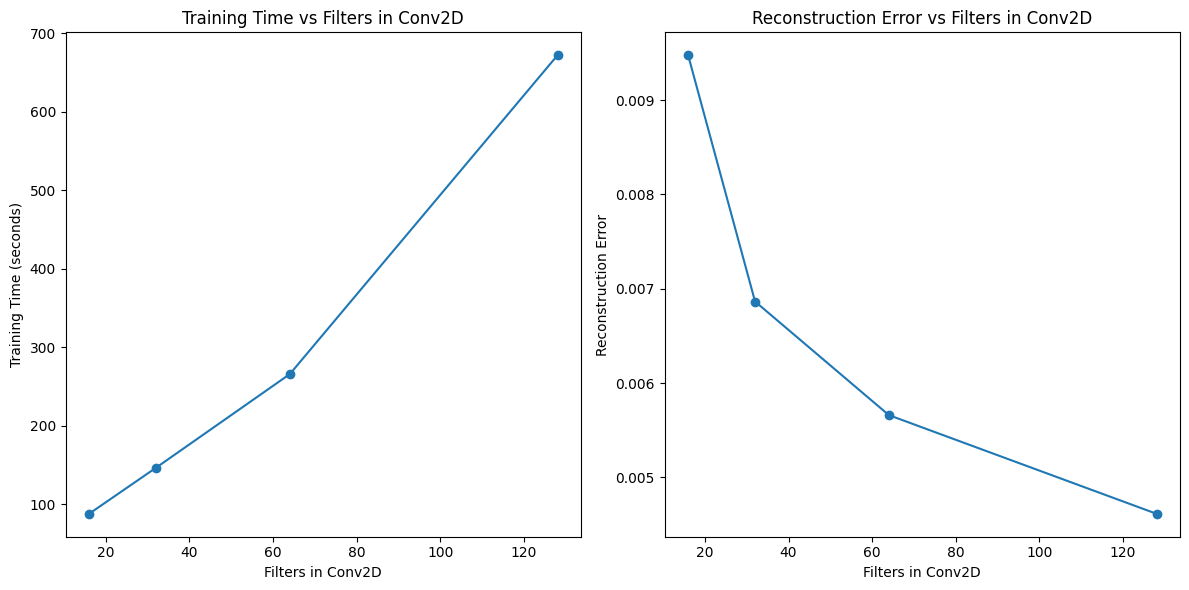

In [ ]:
filters = [128, 64, 32, 16]

training_times = []
reconstruction_errors = []

for filter in filters:
    autoencoder = build_autoencoder(num_layers_encoder = 2,filters_encoder = filter, kernel_size_encoder = (3,3))
    training_time, _ = train_autoencoder(autoencoder, X_train_norm, X_test_norm)
    reconstruction_error = evaluate_autoencoder(autoencoder, X_test_norm)

    training_times.append(training_time)
    reconstruction_errors.append(reconstruction_error)

plot_results(filters, training_times, reconstruction_errors, 'Filters in Conv2D')

**Influence of Kernel Size in Convolutional Layers**

Model's Bottleneck Feature Vector: 2048
Model's Bottleneck Feature Vector: 2048
Model's Bottleneck Feature Vector: 2048
Model's Bottleneck Feature Vector: 2048


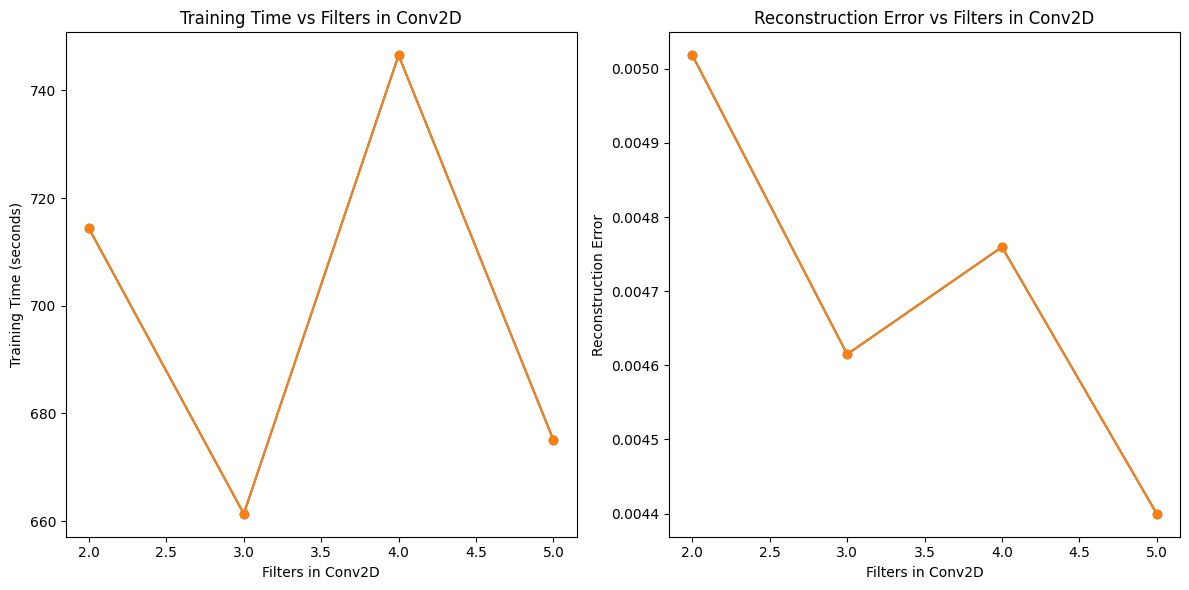

In [ ]:
kernel_sizes= [(2,2), (3,3), (4,4), (5,5)]

training_times = []
reconstruction_errors = []

for kernel_size in kernel_sizes:
    autoencoder = build_autoencoder(num_layers_encoder = 2,filters_encoder = 128, kernel_size_encoder = kernel_size)
    training_time, _ = train_autoencoder(autoencoder, X_train_norm, X_test_norm)
    reconstruction_error = evaluate_autoencoder(autoencoder, X_test_norm)

    training_times.append(training_time)
    reconstruction_errors.append(reconstruction_error)

plot_results(kernel_sizes, training_times, reconstruction_errors, 'Kernel Sizes in Conv2D')

# **Denoising AutoEncoders for Cifar-10**

For the Denoising AutoEncoder, we will put noisy data into the encoder's input and compare the decoder's output with clean data.

The expansion to the Denoising AutoEncoder is implemented to test the enhanced functionalities that can be tackled when altering the original simple architectures of AutoEncoders.

In [ ]:
# Reseting the workspace since the memory is not infinite
%reset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from skimage.metrics import structural_similarity

Loading the Data after the Reset

In [ ]:
(train_data_clean,_),(test_data_clean,_) = keras.datasets.cifar10.load_data()

In [ ]:
train_data_clean = train_data_clean.astype('float32') / 255.0
test_data_clean = test_data_clean.astype('float32') / 255.0

Setting again the metrics

In [ ]:
def mse_rmse_calculation(data_1, data_2, string):
    mse = np.square(np.subtract(data_1, data_2)).mean()
    rmse = np.sqrt(mse)

    # Display the results
    print(f'Metrics of {string}:')
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")

    return mse,rmse

In [ ]:
def ssim_calculation(X, X_reconstructed, string):

  ssim_values = []

  for original_image, recostructed_image in zip(X, X_reconstructed):
      ssim_value = structural_similarity(original_image, recostructed_image, channel_axis = -1)
      ssim_values.append(ssim_value)

  average_ssim = np.mean(ssim_values)

  print(f"Average Structural Similarity Index (SSIM) in {string}: {average_ssim}")

  return average_ssim

Add Gaussian/Normal Noise to the Data

In [ ]:
def add_noise_and_clip_data(data):
    noise = np.random.normal(loc=0.0, scale=0.1, size=data.shape) # generate noise from normal distribution with zero mean and 0.1 standard deviation
    # Add noise and then clip the image data between 0. and 1. again so as to avoid errors
    data = data + noise
    data = np.clip(data, 0., 1.)
    return data.astype('float32') # converting again to the expected data type

train_data_noisy = add_noise_and_clip_data(train_data_clean)
test_data_noisy = add_noise_and_clip_data(test_data_clean)

Image with Noise

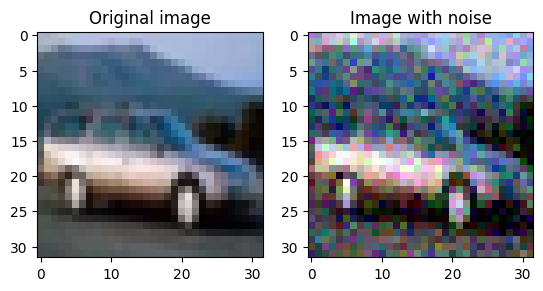

In [ ]:
idx = 4
plt.subplot(1,2,1)
plt.imshow(train_data_clean[idx])
plt.title('Original image')
plt.subplot(1,2,2)
plt.imshow(train_data_noisy[idx])
plt.title('Image with noise')
plt.show()

Create Functions for the layer creating since the models are complex

In [ ]:
def conv_block(x, filters, kernel_size, strides=2):
    x = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    return x

def deconv_block(x, filters, kernel_size, strides=2):
    x = keras.layers.Conv2DTranspose(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    return x

In [ ]:
def denoising_autoencoder():
    inputs = keras.layers.Input(shape=(32, 32, 3), name='dae_input')
    conv_block1 = conv_block(inputs, 32, 3)
    conv_block2 = conv_block(conv_block1, 64, 3)
    conv_block3 = conv_block(conv_block2, 128, 3)
    conv_block4 = conv_block(conv_block3, 256, 3)
    conv_block5 = conv_block(conv_block4, 256, 3, 1)

    deconv_block1 = deconv_block(conv_block5, 256, 3)
    merge1 = keras.layers.Concatenate()([deconv_block1, conv_block3])
    deconv_block2 = deconv_block(merge1, 128, 3)
    merge2 = keras.layers.Concatenate()([deconv_block2, conv_block2])
    deconv_block3 = deconv_block(merge2, 64, 3)
    merge3 = keras.layers.Concatenate()([deconv_block3, conv_block1])
    deconv_block4 = deconv_block(merge3, 32, 3)

    final_deconv = keras.layers.Conv2DTranspose(filters=3,kernel_size=3,padding='same')(deconv_block4)

    outputs = keras.layers.Activation('sigmoid', name='dae_output')(final_deconv)

    return keras.models.Model(inputs, outputs, name='dae')

In [ ]:
dae = denoising_autoencoder()

dae.compile(loss='mse', optimizer='adam')

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

dae.fit(train_data_noisy,train_data_clean,validation_data=(test_data_noisy, test_data_clean),epochs=30,batch_size=128,callbacks=[early_stopping])

Epoch 1/30
391/391 [==============================] - 20s 29ms/step - loss: 0.0046 - val_loss: 0.0060
Epoch 2/30
391/391 [==============================] - 9s 22ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 3/30
391/391 [==============================] - 9s 24ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 4/30
391/391 [==============================] - 9s 24ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 5/30
391/391 [==============================] - 9s 24ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 6/30
391/391 [==============================] - 9s 22ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 7/30
391/391 [==============================] - 9s 22ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 8/30
391/391 [==============================] - 9s 24ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 9/30
391/391 [==============================] - 9s 24ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 10/30
391/391 [==============================] - 9s 22ms/step - loss: 0.0018 - val_l

In [ ]:
test_data_denoised = dae.predict(test_data_noisy)

313/313 [==============================] - 2s 3ms/step


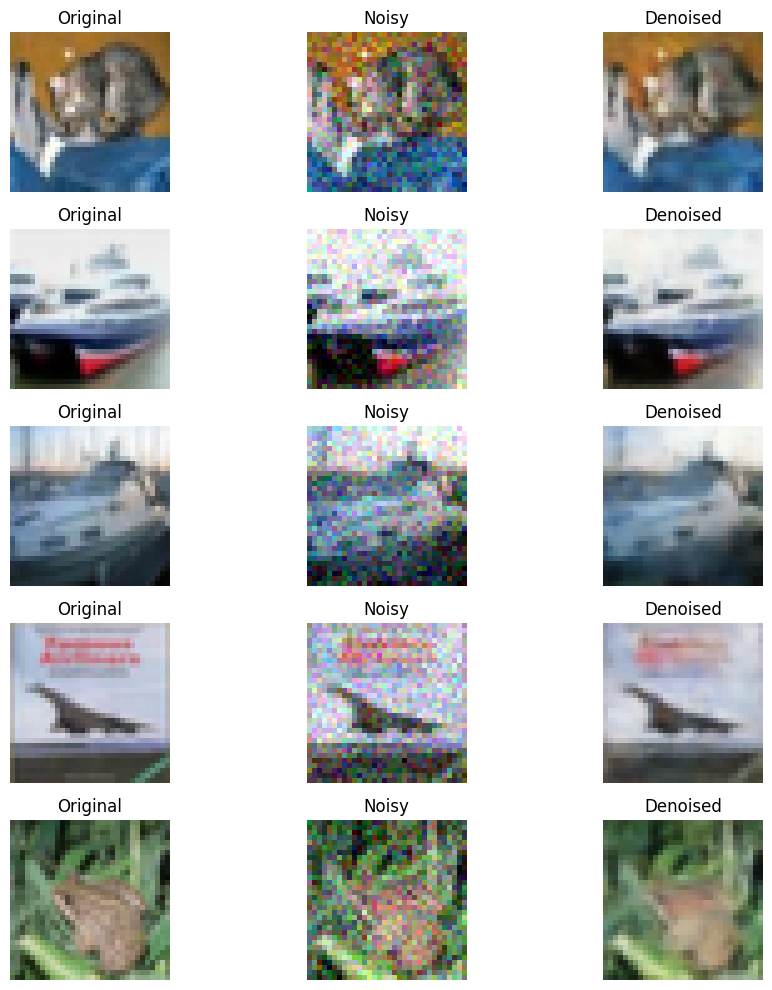

In [ ]:
num_images = 5
fig, axes = plt.subplots(num_images, 3, figsize=(10, 2*num_images))

for idx in range(num_images):
    axes[idx, 0].imshow(test_data_clean[idx])
    axes[idx, 0].set_title('Original')
    axes[idx, 0].axis('off')

    axes[idx, 1].imshow(test_data_noisy[idx])
    axes[idx, 1].set_title('Noisy')
    axes[idx, 1].axis('off')

    axes[idx, 2].imshow(test_data_denoised[idx])
    axes[idx, 2].set_title('Denoised')
    axes[idx, 2].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
noisy_clean_mse = mse_rmse_calculation(test_data_clean, test_data_noisy,"Noisy Data")
denoised_clean_mse = mse_rmse_calculation(test_data_denoised, test_data_clean, "Denoised Data")
ssim_calculation(test_data_clean, test_data_noisy,"Noisy Data")
ssim_calculation(test_data_denoised, test_data_clean, "Denoised Data")

Metrics of Noisy Data:
Mean Squared Error (MSE): 0.009302790276706219
Root Mean Squared Error (RMSE): 0.09645097702741623
Metrics of Denoised Data:
Mean Squared Error (MSE): 0.0017039168160408735
Root Mean Squared Error (RMSE): 0.041278526186943054
Average Structural Similarity Index (SSIM) in Noisy Data: 0.7143121361732483
Average Structural Similarity Index (SSIM) in Denoised Data: 0.9319579005241394


0.9319579

We can see how the Denoised Data have increased SSIM related with the noised Data.

## Hyperparameter Tuning for other optimal Denoising autoencoder architectures

In [ ]:
!pip install keras-tuner --upgrade
from keras_tuner.tuners import RandomSearch,BayesianOptimization,GridSearch
from keras_tuner.engine.hyperparameters import HyperParameters
import keras
# Early Stopping for the training process
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

The architecture followed for the construction of the denoising autoencoder is similary with the simple AutoEncoders. However, the objective of the Neural Network is different, since the goal is based on noisy data to reconstruct the original denoised data.

In [ ]:
def build_denoising_autoencoder(hp):
    input_layer = keras.layers.Input(shape=(32, 32, 3))
    x = input_layer

    # Add Gaussian noise to input (adjust the noise level as needed)
    noise = hp.Float('noise_level', min_value=0.01, max_value=0.1)
    x_noisy = keras.layers.GaussianNoise(stddev=noise)(x)

    # Encoder
    encoder_layers = []
    for i in range(hp.Int('num_layers_encoder', min_value=0, max_value=3)):
        x_noisy = keras.layers.Conv2D(hp.Int(f'filters_encoder_{i}', min_value=32, max_value=256, step=32),
                                hp.Int(f'kernel_size_encoder_{i}', min_value=3, max_value=5),
                                padding='same', activation='relu')(x_noisy)
        encoder_layers.append(x_noisy)
        x_noisy = keras.layers.MaxPooling2D(pool_size=(2, 2))(x_noisy)

    # Last layer -> bottleneck
    filters_last = hp.Int('filters_encoder_last', min_value=4, max_value=128, step=32)
    kernel_size_last = hp.Int('kernel_size_encoder_last', min_value=2, max_value=3)
    x_noisy = keras.layers.Conv2D(filters_last, kernel_size_last, padding='same', activation='relu')(x_noisy)
    # Bottleneck layer
    bottle_neck = x_noisy

    # Decoder
    x_noisy = keras.layers.Conv2D(filters_last, kernel_size_last, padding='same', activation='relu')(x_noisy)

    for i, encoder_layer in enumerate(reversed(encoder_layers)):
        x_noisy = keras.layers.Conv2D(encoder_layer.shape[-1],
                                encoder_layer.shape[1:3],
                                padding='same', activation='relu')(x_noisy)
        x_noisy = keras.layers.UpSampling2D(size=(2, 2))(x_noisy)

    # Output layer
    output_layer = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x_noisy)

    # Build the denoising autoencoder model
    denoising_autoencoder = keras.models.Model(inputs=input_layer, outputs=output_layer)

    # Compile the denoising autoencoder
    optimizer = keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log'))
    denoising_autoencoder.compile(loss='mean_squared_error', metrics=['accuracy'], optimizer=optimizer)

    return denoising_autoencoder

# Define the hyperparameter search space
hyperparameters = HyperParameters()

# Initialize the tuner
tuner = RandomSearch(
    build_denoising_autoencoder,
    objective='val_loss',  # You might need to adjust this based on your task
    max_trials=5,
    hyperparameters=hyperparameters,
    directory='tuner_dir',  # Specify a directory to store tuner results
    project_name='denoising_autoencoder')

# Perform the search
tuner.search(train_data_noisy,train_data_clean,validation_data=(test_data_noisy, test_data_clean),epochs=30,batch_size=128,callbacks=[early_stopping])

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

Trial 7 Complete [00h 04m 26s]
val_loss: 0.0018165826331824064

Best val_loss So Far: 0.0018165826331824064
Total elapsed time: 00h 24m 31s


In [ ]:
test_data_denoised = best_model.predict(test_data_noisy)

313/313 [==============================] - 1s 2ms/step


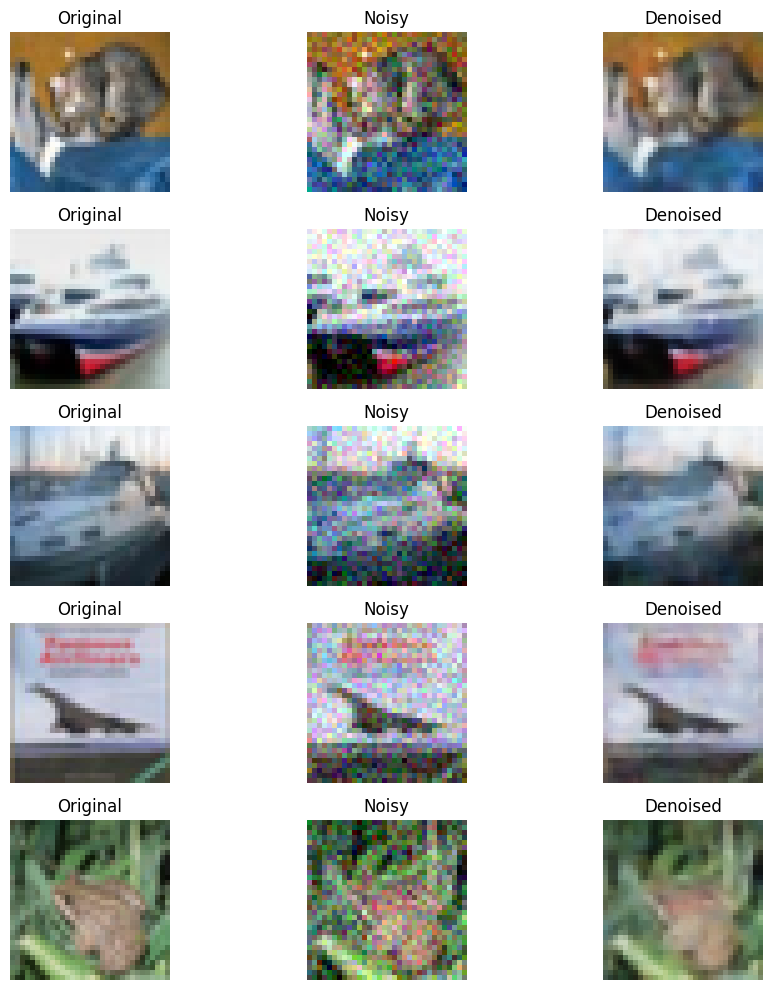

In [ ]:
num_images = 5
fig, axes = plt.subplots(num_images, 3, figsize=(10, 2*num_images))

for idx in range(num_images):
    axes[idx, 0].imshow(test_data_clean[idx])
    axes[idx, 0].set_title('Original')
    axes[idx, 0].axis('off')

    axes[idx, 1].imshow(test_data_noisy[idx])
    axes[idx, 1].set_title('Noisy')
    axes[idx, 1].axis('off')

    axes[idx, 2].imshow(test_data_denoised[idx])
    axes[idx, 2].set_title('Denoised')
    axes[idx, 2].axis('off')

plt.tight_layout()
plt.show()

Metrics of the optimal model

In [ ]:
noisy_clean_mse = mse_rmse_calculation(test_data_clean, test_data_noisy,"Noisy Data")
denoised_clean_mse = mse_rmse_calculation(test_data_denoised, test_data_clean, "Denoised Data")
ssim_calculation(test_data_clean, test_data_noisy,"Noisy Data")
ssim_calculation(test_data_denoised, test_data_clean, "Denoised Data")

Metrics of Noisy Data:
Mean Squared Error (MSE): 0.009302790276706219
Root Mean Squared Error (RMSE): 0.09645097702741623
Metrics of Denoised Data:
Mean Squared Error (MSE): 0.0018165799556300044
Root Mean Squared Error (RMSE): 0.04262135550379753
Average Structural Similarity Index (SSIM) in Noisy Data: 0.7143121361732483
Average Structural Similarity Index (SSIM) in Denoised Data: 0.9273107647895813


0.92731076

# **Variational AutoEncoders for Cifar-10**

In this chapter, we introduce variational autoencoders since the simple autoencoders cannot generate new data. Thus, the generative process is now possible. This approach is performed in order to get a taste of a generative model.

VAEs provide a probabilistic framework for learning representations of high-dimensional data. They have demonstrated success in capturing meaningful latent structures and generating diverse and realistic samples.




In [ ]:
# Resetting the workspace because the memory is not infinite.
%reset

In [ ]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from keras.datasets import cifar10
from keras import backend as K

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize pixel values to be between 0 and 1
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Define VAE architecture

# This variable represents the dimensionality of the latent space.
# So each image is going to be encoded and thus represented by 200 values (100 values for mean and 100 for log - standard deviation)
# (original 32*32*3)

# Note: The log-variance is used because according to some articles can lead to numerical stability and simplifies mathematical derivations.
latent_dim = 100

# Encoder
# The encoder for VAE is similar to the ones already created for the simple AutoEncoder with the
# addition of a flatten and a dense layer for specifying the latent dimensions
encoder_inputs = keras.Input(shape=(32, 32, 3), name = "encoder_input")
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same", name = "conv2d_1")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same", name = "conv2d_2")(x)
x = layers.Flatten(name = "flatten")(x)
x = layers.Dense(2 * latent_dim)(x)

# Sample z
# The vector of means and log-variance are initially extracted
z_mean = x[:, :latent_dim]
z_log_var = x[:, latent_dim:]
# The following Lambda Layer is used to sample a point from the latent space using the reparameterization trick to add randomness
# The inputs of the layer contain the mean and log-variance of the Gaussian distribution in the latent space of the VAE
# The h[0] is the z_mean and the h[1] is the z_log_var from which the standard deviation is computed.
# The tf.random.normal is used to take random samples from a Normal Distribution with shape (batch_size,latent_dim)
z = layers.Lambda(lambda h: h[0] + tf.exp(0.5 * h[1]) * tf.random.normal(shape=(tf.shape(h[0])[0], latent_dim)))([z_mean, z_log_var])
# the above line in summary computes the z = z_mean + tf.exp(0.5 * z_log_var) * epsilon

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# Decoder -> will take the latent vector and try to recostruct the image
decoder_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(8 * 8 * 64, activation="relu")(decoder_inputs)
x = layers.Reshape((8, 8, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)

decoder = keras.Model(decoder_inputs, decoder_outputs, name="decoder")

# VAE -> combine the 2 models (Encoder and Decoder in order to form the full model)
vae_inputs = encoder_inputs
vae_outputs = decoder(encoder(vae_inputs)[2])
vae = keras.Model(vae_inputs, vae_outputs, name="vae")

# VAE Loss - try to create a custom function for calculating the loss of the Variational AutoEncoder
# The Loss of the VAE is a combination of cross-entropy loss which is the reconstruction loss
# and KL divergence loss which calculated basically how well the latent vector can describe the data distribution

def vae_loss(x, x_decoded_mean):
    z_mean, z_log_var, z = encoder(x)

    # Reconstruct Loss (Binary cross-entropy)
    reconstruction_loss = keras.losses.binary_crossentropy(tf.keras.backend.flatten(x), tf.keras.backend.flatten(x_decoded_mean)) * 32 * 32 * 3

    # KL Divergence Loss
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)

    return K.mean(reconstruction_loss + kl_loss) # Combine the two losses for the final loss

vae.compile(optimizer='adam', loss=vae_loss)

# Train the VAE using again early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

vae.fit(x_train,x_train,validation_data=(x_test, x_test),epochs=100,batch_size=128,callbacks=[early_stopping])


Epoch 1/100
391/391 [==============================] - 9s 15ms/step - loss: 1942.0187 - val_loss: 1865.9333
Epoch 2/100
391/391 [==============================] - 5s 13ms/step - loss: 1848.3309 - val_loss: 1843.2137
Epoch 3/100
391/391 [==============================] - 5s 13ms/step - loss: 1835.9525 - val_loss: 1835.3361
Epoch 4/100
391/391 [==============================] - 5s 12ms/step - loss: 1830.6772 - val_loss: 1831.6375
Epoch 5/100
391/391 [==============================] - 5s 14ms/step - loss: 1827.7109 - val_loss: 1829.9102
Epoch 6/100
391/391 [==============================] - 5s 12ms/step - loss: 1825.6703 - val_loss: 1828.1071
Epoch 7/100
391/391 [==============================] - 5s 13ms/step - loss: 1824.3130 - val_loss: 1826.3984
Epoch 8/100
391/391 [==============================] - 5s 13ms/step - loss: 1823.0699 - val_loss: 1825.7246
Epoch 9/100
391/391 [==============================] - 5s 13ms/step - loss: 1822.2076 - val_loss: 1824.6232
Epoch 10/100
391/391 [======

In [ ]:
vae.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 3)]       0         
                                                                 
 encoder (Functional)        [(None, 100),             838792    
                              (None, 100),                       
                              (None, 100)]                       
                                                                 
 decoder (Functional)        (None, 32, 32, 3)         469955    
                                                                 
Total params: 1308747 (4.99 MB)
Trainable params: 1308747 (4.99 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Generate new images
@tf.function
def generate_images(latent_vectors):
    return decoder(latent_vectors, training=False)

num_samples = 12
random_latent_vectors = np.random.normal(size=(num_samples, latent_dim))
generated_images = generate_images(tf.convert_to_tensor(random_latent_vectors, dtype=tf.float32)).numpy()

Loading a trained CNN model to see if the new data can be captured

In [ ]:
from keras.models import load_model
# Loading a Convolutional Neural Network with high accuracy ~ 80%
loaded_model = load_model('cnn_20_epochs.h5')

In [ ]:
from sklearn.metrics import accuracy_score
predictions_generated = loaded_model.predict(generated_images)
predicted_labels_generated = np.argmax(predictions_generated, axis=1)

1/1 [==============================] - 0s 30ms/step


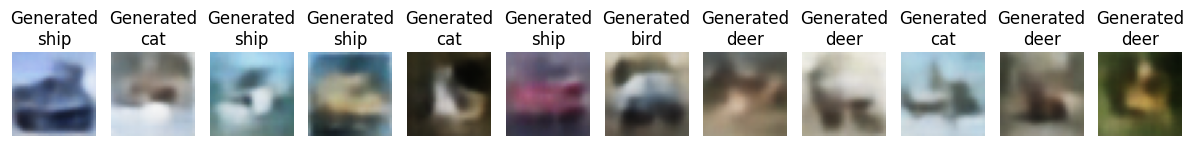

In [ ]:
import matplotlib.pyplot as plt

labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
# Display the images along with predicted class labels
plt.figure(figsize=(12, 6))
for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(generated_images[i])
    plt.title(f"Generated\n{labels[predicted_labels_generated[i]]}", fontsize=12)
    plt.axis('off')

plt.tight_layout()
plt.show()